In [1]:
import csv
import os 
import ROOT
import math
import numpy as np
from ROOT import *
from etaprogress.progress import ProgressBar
#from lhereader import readLHEF 

Welcome to JupyROOT 6.22/06


In [2]:
class Particle():
    def __init__(self):
        self.TLV=TLorentzVector()
 
    def GetTLV (self):    
        return self.TLV

    def Pt(self):
        # Returns transverse momentum
        TLV = self.TLV
        return TLV.Pt()
    
    def P(self):
        # Returns full momentum
        TLV = self.TLV
        return TLV.P()
    
    def Pl(self):
        # Returns longitudinal momentum
        p = self.TLV.P()
        pt= self.TLV.Pt()
        return TMath.Sqrt(p*p-pt*pt)

    def eta(self):
        # Returns jet pseudorapidity
        TLV = self.TLV
        return TLV.Eta()

    ### Delta methods

    def DeltaR(self, v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        return TLV1.DeltaR(TLV2)

    def DeltaEta(self, v2):
        return self.eta() - v2.eta()

    def DeltaPhi(self, v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        return TLV1.DeltaPhi(TLV2)

    def sDeltaPT(self, v2):
        return self.PT() - v2.PT()

    def vDeltaPT(self, v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        a=TVector2(TLV1.Px(), TLV1.Py())
        b=TVector2(TLV2.Px(), TLV2.Py())
        c=a-b
        return c.Mod()

    def vDeltaP(self,v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        a=TVector3(TLV1.Px(), TLV1.Py(), TLV1.Pz())
        b=TVector3(TLV2.Px(), TLV2.Py(), TLV2.Pz())
        c=a-b
        return c.Mag()
    
class JetVector(Particle):
    def __init__(self, event, j):
        super().__init__()
        self.TLV.SetPtEtaPhiM(
            event.GetLeaf("Jet.PT").GetValue(j), 
            event.GetLeaf("Jet.Eta").GetValue(j), 
            event.GetLeaf("Jet.Phi").GetValue(j), 
            event.GetLeaf("Jet.Mass").GetValue(j)
        )
        self.BTag   = event.GetLeaf("Jet.BTag").GetValue(j)
        self.Charge = event.GetLeaf("Jet.Charge").GetValue(j)
        self.TauTag = event.GetLeaf("Jet.TauTag").GetValue(j)
        
    def getCharge(self):
        return self.Charge
    
class MuonVector(Particle):
    def __init__(self, event, j):
        super().__init__()
        self.TLV.SetPtEtaPhiM(
            event.GetLeaf("Muon.PT").GetValue(j), 
            event.GetLeaf("Muon.Eta").GetValue(j), 
            event.GetLeaf("Muon.Phi").GetValue(j), 
            0.1056583755
        )
        self.Charge = event.GetLeaf("Muon.Charge").GetValue(j)

    ### Retrieval methods
    def getCharge(self):
        return self.Charge
    
class ElectronVector(Particle):
    def __init__(self, event, j):
        super().__init__()
        self.TLV.SetPtEtaPhiM(
            event.GetLeaf("Electron.PT").GetValue(j), 
            event.GetLeaf("Electron.Eta").GetValue(j), 
            event.GetLeaf("Electron.Phi").GetValue(j), 
            0.000511
        )
        self.Charge = event.GetLeaf("Electron.Charge").GetValue(j)
    
    ### Retrieval methods
    def getCharge(self):
        return self.Charge

In [4]:
!curl -O https://raw.githubusercontent.com/cfrc2694/Pheno_BSM/main/SimulationsPaths.csv
class DelphesSignal(JetVector):
    def __init__(self, name_signal=None):
        # Reading diccionary path
        data = {}
        with open("SimulationsPaths.csv", 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                name_signal_dict = row.pop(0)
                data[name_signal_dict] = [*row]
        self.name=name_signal
        
        # verify dictionary path    Is name_signal bool?
        if name_signal:
            try:
                path_to_signal = data[self.name][0] # Path
            except KeyError:
                raise Exception("Error: " + name_signal + " Signal not defined")
            bkg = data[self.name][1] # BKG
            bkg = True if bkg == "True" else False
        else:
            self.name="SingleLQ_500"
            path_to_signal = data[self.name][0]
            bkg = False
        
        self.tree = self.getTree(path_to_signal, bkg)
        load=self.name+" imported!\n"
        load+=str(self.tree.GetEntries()) + " events have been loaded from\n"
        load+=path_to_signal+"\n"
        print(load)
        #self.declareHistos()
        
    def getTree(self,path, bkg=False):
        path_to_signal=path
        tree = TChain('Delphes;1')
        if not(bkg):
            ev_dir = path_to_signal + "/Events/"
            dirs=next(os.walk(ev_dir))[1]
            for folder in dirs :
                directory = str(folder+'/tag_1_delphes_events.root')
                tree.Add(ev_dir + directory)
            return tree
        else:
            ev_dir=path
            dirs=next(os.walk(ev_dir))[1]
            for folder in dirs :
                if (folder !="Cards" and folder != "ParamCard"):
                    directory=ev_dir+folder
                    directory+= "/Events/run_01"  +"/m_delphes_events.root"
                    tree.Add(directory)
            return tree


In [5]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
        self.declareHistos()
        
    def declareHistos(self):
        self.hist_list=TList()

        def defineHisto(name, title, x_label, y_label, bins, lo, hi):
            h=TH1F(name, "{}; {}; {}".format(title, x_label, y_label), bins, lo, hi)
            h.SetDirectory(0)
            self.hist_list.Add(h)

        #cutflow histogram to record the absolute efficiency of each cut
        defineHisto('e-cutflow', 'Cutflow (electrons)', 'Cut', 'Events', 10, 0, 10)
        defineHisto('mu-cutflow', 'Cutflow (muons)', 'Cut', 'Events', 10, 0, 10)
        #CutFlowHist

        #Histogram to record  Number of Jets  reported by Delphes
        defineHisto('n_jets', 'Number of Jets', 'Jet multiplicity', 'Events', 10, 0, 10)
        
        #Histogram to record  Number of good Jets reconstructed
        defineHisto('n_good_jets',
            'Number of Good Jets', 'Jet multiplicity', 'Events',
            10,0,10
        )
        
        
        #Histograms to Record  the reconstructed mass of LQ
        defineHisto('m_LQ_tau1', 
            'M_{b+#tau}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_tau2', 
            'M_{b+#tau}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_tau1_met', 
            'M_{b+#tau+MET}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_tau2_met', 
            'M_{b+#tau+MET}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_e', 
            'M_{b+e}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_e_met', 
            'M_{b+e+MET}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_mu', 
            'M_{b+#mu}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_mu_met', 
            'M_{b+#mu+MET}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        
        #Histograms to Record the pt of LQ

        defineHisto('pt_LQ', 
            'Pt_{b+#tau', 'Transverse Momentum(GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        
        defineHisto('pt_LQe', 
            'Pt_{b+e}', 'Transverse Momentum(GeV)', 'Events", 
            40, 0.0, 2000.0
        )
        
        #Histograms to Record  the pt of all reconstructed jets
        
        h=TH1F(
            "pt_all_jets", 
            "Pt_{all-jets}; Pt(GeV); Events", 
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "pt_all_ljets", 
            "Pt_{all-light-jets}; Pt(GeV); Events", 
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "pt_all_bjets", 
            "Pt_{all-bjets}; Pt(GeV); Events", 
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "pt_all_taujets", 
            "Pt_{all-#tau jets}; Pt(GeV); Events", 
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        #Histograms to Record  the eta of all reconstructed jets
        
        h=TH1F(
            "eta_all_jets", 
            "#eta_{all-jets}; #eta; Events", 
            100, -5, 5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "eta_all_ljets", 
            "#eta_{all-light-jets}; #eta; Events", 
            100, -5, 5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "eta_all_bjets", 
            "#eta_{all-bjets}; #eta; Events", 
            100, -5, 5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        
        h=TH1F(
            "eta_all_taujets", 
            "#eta_{all-#tau jets}; #eta; Events", 
            100, -5, 5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        #Histograms to record the pt of each output particle
        #############################
        h=TH1F(
            "pt_lead_ljet", 
            "Pt_{j_{L}}; Pt(GeV); Events", 
            30, 0.0, 1500.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "pt_lead_bjet", 
            "Pt_{b_{L}}; Pt(GeV); Events", 
            30, 0.0, 1500.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "pt_lead_tau", 
            "Pt_{#tau_{L}}; Pt(GeV); Events", 
            30, 0.0, 1500.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "pt_slead_tau", 
            "Pt_{#tau_{S}}; Pt(GeV); Events", 
            30, 0.0, 1500.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        

        #############################
        #Histograms to record the eta of each output particle
        h=TH1F(
            "eta_lead_ljet", 
            "#eta_{j_{L}}; #eta; Events", 
            20, -5, 5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "eta_lead_bjet", 
            "#eta_{b_{L}}; #eta; Events", 
            20, -5, 5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "eta_lead_tau", 
            "#eta_{#tau_{L}}; #eta; Events", 
            20, -5, 5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "eta_slead_tau", 
            "#eta_{#tau_{S}}; #eta; Events", 
            20, -5, 5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        #############################
        
        
        #Histograms to record the delta eta between each possible pair of jets
        
        h=TH1F(
            "deltaEta_taus",
            "#Delta #eta_{(#tau_{1} #tau_{2})}; #Delta #eta; Events",
            40,-5,5
        )
        
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaEta_b_ltau",
            "#Delta #eta_{(b_{L} #tau_{L})}; #Delta #eta; Events",
            40,-5,5
        )
        
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaEta_b_sltau",
            "#Delta #eta_{(b_{L} #tau_{S})}; #Delta #eta; Events",
            20,-5,5
        )
        
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaEta_j_ltau",
            "#Delta #eta_{(j_{L} #tau_{L})}; #Delta #eta; Events",
            40,-5,5
        )
        
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaEta_j_sltau",
            "#Delta #eta_{(j_{L} #tau_{S})}; #Delta #eta; Events",
            40,-5,5
        )
        
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaEta_b_j",
            "#Delta #eta_{(b_{L} j_{L})}; #Delta #eta; Events",
            40,-5,5
        )
        
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        #############################
        
        #Histograms to record the delta phi between each possible pair of jets
        h=TH1F(
            "deltaPhi_taus",
            "#Delta #phi_{(#tau_{1} #tau_{2})}; #Delta #eta; Events",
            28,-3.5,3.5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaPhi_b_ltau",
            "#Delta #phi_{(b_{L} #tau_{L})}; #Delta #eta; Events",
            28,-3.5,3.5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaPhi_b_sltau",
            "#Delta #phi_{(b_{L} #tau_{S})}; #Delta #eta; Events",
            28,-3.5,3.5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaPhi_j_ltau",
            "#Delta #phi_{(j_{L} #tau_{L})}; #Delta #eta; Events",
            28,-3.5,3.5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaPhi_j_sltau",
            "#Delta #phi_{(j_{L} #tau_{S})}; #Delta #eta; Events",
            28,-3.5,3.5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "deltaPhi_b_j",
            "#Delta #phi_{(b_{L} j_{L})}; #Delta #eta; Events",
            28,-3.5,3.5
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)

        
        #Histograms to record the delta phi between each possible pair of jets
        h=TH1F(
            "vDeltaPT_taus",
            "#Delta #vec{PT}_{(#tau_{1} #tau_{2})}; #Delta PT (GeV); Events",
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "vDeltaPT_b_ltau",
            "#Delta #vec{PT}_{(b_{L} #tau_{L})}; #Delta PT (GeV); Events",
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "vDeltaPT_b_sltau",
            "#Delta #vec{PT}_{(b_{L} #tau_{S})}; #Delta PT (GeV); Events",
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "vDeltaPT_j_ltau",
            "#Delta #vec{PT}_{(j_{L} #tau_{L})}; #Delta PT (GeV); Events",
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "vDeltaPT_j_sltau",
            "#Delta #vec{PT}_{(j_{L} #tau_{S})}; #Delta PT (GeV); Events",
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        h=TH1F(
            "vDeltaPT_b_j",
            "#Delta #vec{PT}_(b_{L} j_{L})}; #Delta PT (GeV); Events",
            40, 0.0, 2000.0
        )
        h.SetDirectory(0)
        self.hist_list.Add(h)
        
        return self.hist_list

In [6]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
    def writelist(self):
        !rm -rf {self.name}.root
        f =TFile(self.name+".root","RECREATE")
        self.hist_list.Write("histlist", TObject.kSingleKey)
        f.ls()
        print(self.name+" Done!")

In [7]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
        
    def fillJetHistos(self,JD):
        #All jets kinematics histos
        for jet in JD['all_jets']:
            self.hist_list.FindObject("pt_all_jets").Fill(jet.TLV.Pt())
            self.hist_list.FindObject("eta_all_jets").Fill(jet.TLV.Eta())
        
        for jet in JD['l_jets']:
            self.hist_list.FindObject("pt_all_ljets").Fill(jet.TLV.Pt())
            self.hist_list.FindObject("eta_all_ljets").Fill(jet.TLV.Eta())
            
        for jet in JD['b_jets']:
            self.hist_list.FindObject("pt_all_bjets").Fill(jet.TLV.Pt())
            self.hist_list.FindObject("eta_all_bjets").Fill(jet.TLV.Eta())
            
        for jet in JD['tau_jets']:
            self.hist_list.FindObject("pt_all_taujets").Fill(jet.TLV.Pt())
            self.hist_list.FindObject("eta_all_taujets").Fill(jet.TLV.Eta())
        
        #Reconstructed mass
        
        lqTLV=JD['b_jets'][0].TLV + JD['tau_jets'][0].TLV
        self.hist_list.FindObject("m_LQ").Fill(lqTLV.M())
        self.hist_list.FindObject("pt_LQ").Fill(lqTLV.Pt())
        
        lqTLV=JD['b_jets'][0].TLV + JD['tau_jets'][1].TLV
        self.hist_list.FindObject("m_LQs").Fill(lqTLV.M())
        self.hist_list.FindObject("pt_LQs").Fill(lqTLV.Pt())
        
        #Pt Histos
        
        self.hist_list.FindObject("pt_lead_ljet").Fill(
            JD['l_jets'][0].TLV.Pt()
        )
        self.hist_list.FindObject("pt_lead_bjet").Fill(
            JD['b_jets'][0].TLV.Pt()
        )
        self.hist_list.FindObject("pt_lead_tau").Fill(
            JD['tau_jets'][0].TLV.Pt()
        )
        self.hist_list.FindObject("pt_slead_tau").Fill(
            JD['tau_jets'][1].TLV.Pt()
        )
        
        #Eta Histos
        
        self.hist_list.FindObject("eta_lead_ljet").Fill(
            JD['l_jets'][0].TLV.Eta()
        )
        self.hist_list.FindObject("eta_lead_bjet").Fill(
            JD['b_jets'][0].TLV.Eta()
        )
        self.hist_list.FindObject("eta_lead_tau").Fill(
            JD['tau_jets'][0].TLV.Eta()
        )
        self.hist_list.FindObject("eta_slead_tau").Fill(
            JD['tau_jets'][1].TLV.Eta()
        )
        
        #Delta Eta Histos
        
        self.hist_list.FindObject("deltaEta_taus").Fill(
            JD['tau_jets'][0].DeltaEta(JD['tau_jets'][1])
        )
        
        self.hist_list.FindObject("deltaEta_b_ltau").Fill(
            JD['b_jets'][0].DeltaEta(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("deltaEta_b_sltau").Fill(
            JD['b_jets'][0].DeltaEta(JD['tau_jets'][1])
        )
        
        self.hist_list.FindObject("deltaEta_j_ltau").Fill(
            JD['l_jets'][0].DeltaEta(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("deltaEta_j_sltau").Fill(
            JD['l_jets'][0].DeltaEta(JD['tau_jets'][1])
        )
        
        self.hist_list.FindObject("deltaEta_b_j").Fill(
            JD['b_jets'][0].DeltaEta(JD['l_jets'][0])
        )
        
        ########
        
        self.hist_list.FindObject("deltaPhi_taus").Fill(
            JD['tau_jets'][0].DeltaPhi(JD['tau_jets'][1])
        )
        
        self.hist_list.FindObject("deltaPhi_b_ltau").Fill(
            JD['b_jets'][0].DeltaPhi(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("deltaPhi_b_sltau").Fill(
            JD['b_jets'][0].DeltaPhi(JD['tau_jets'][1])
        )
        
        self.hist_list.FindObject("deltaPhi_j_ltau").Fill(
            JD['l_jets'][0].DeltaPhi(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("deltaPhi_j_sltau").Fill(
            JD['l_jets'][0].DeltaPhi(JD['tau_jets'][1])
        )
        
        self.hist_list.FindObject("deltaPhi_b_j").Fill(
            JD['b_jets'][0].DeltaPhi(JD['l_jets'][0])
        )
        
        ########
        
        self.hist_list.FindObject("vDeltaPT_taus").Fill(
            JD['tau_jets'][0].vDeltaPT(JD['tau_jets'][1])
        )
        
        self.hist_list.FindObject("vDeltaPT_b_ltau").Fill(
            JD['b_jets'][0].vDeltaPT(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("vDeltaPT_b_sltau").Fill(
            JD['b_jets'][0].vDeltaPT(JD['tau_jets'][1])
        )
        
        self.hist_list.FindObject("vDeltaPT_j_ltau").Fill(
            JD['l_jets'][0].vDeltaPT(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("vDeltaPT_j_sltau").Fill(
            JD['l_jets'][0].vDeltaPT(JD['tau_jets'][1])
        )
        
        self.hist_list.FindObject("vDeltaPT_b_j").Fill(
            JD['b_jets'][0].vDeltaPT(JD['l_jets'][0])
        )

In [8]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
    def getGoodJets(self,event):
        part_dic = {
            'l_jets' : [],
            'b_jets' : [],
            'tau_jets' : [],
            'other_jets' : [],
            'all_jets' : []
        }

        Ljet_Pt_cut=30.
        Ljet_Eta_cut=5.

        bjet_Pt_cut=30.
        bjet_Eta_cut=2.5

        taujet_Pt_cut=20.
        taujet_Eta_cut=2.5

        n_jets=event.Jet.GetEntries()
        
        for j in range(n_jets):
            jet=JetVector(event, j)
            #Classify by type jet according to its Tag
            #apply its corresponding kinematic cut.
            if( jet.BTag==0 and jet.TauTag==0):
                ptcut= (jet.TLV.Pt()>= Ljet_Pt_cut)
                etacut= (abs(jet.TLV.Eta())<= Ljet_Eta_cut)
                if (ptcut and etacut ):
                    part_dic['l_jets'] += [jet]
            elif( jet.BTag==1 and jet.TauTag==0): 
                ptcut= (jet.TLV.Pt()>= bjet_Pt_cut)
                etacut= (abs(jet.TLV.Eta())<= bjet_Eta_cut)
                if (ptcut and etacut ):
                    part_dic['b_jets'] += [jet]
            elif( jet.BTag==0 and jet.TauTag==1): 
                ptcut= (jet.TLV.Pt()>= taujet_Pt_cut)
                etacut= (abs(jet.TLV.Eta())<= taujet_Eta_cut)
                if (ptcut and etacut ):
                    part_dic['tau_jets'] += [jet]
            else: 
                ptcut= (jet.TLV.Pt()>= Ljet_Pt_cut)
                etacut= (abs(jet.TLV.Eta())<= Ljet_Eta_cut)
                if (ptcut and etacut ):
                    part_dic['other_jets'] += [jet]
        part_dic['all_jets']+=part_dic['l_jets']
        part_dic['all_jets']+=part_dic['b_jets']
        part_dic['all_jets']+=part_dic['tau_jets']
        part_dic['all_jets']+=part_dic['other_jets']
        
        part_dic['l_jets'].sort    ( reverse = True , key=Particle.pt)
        part_dic['b_jets'].sort    ( reverse = True , key=Particle.pt)
        part_dic['tau_jets'].sort  ( reverse = True , key=Particle.pt)
        part_dic['all_jets'].sort  ( reverse = True , key=Particle.pt)
        part_dic['other_jets'].sort( reverse = True , key=Particle.pt)
        
        return part_dic


In [20]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
    def eventSelection(self):
        nEvents=self.tree.GetEntries()
        self.goodEventIndex=[]
        bar = ProgressBar(nEvents, max_width=60)
        printEachPercent=20.0
        bar.numerator = 0
        print(self.name, bar)
        nSplits=int(100/printEachPercent)
        last_printed=0
        f = open(self.name+".csv", "w")
        
        for i, event in enumerate(self.tree):
            n_jets=event.Jet.GetEntries()
            self.hist_list.FindObject("cutflow").Fill(0)
            self.hist_list.FindObject("n_jets").Fill(n_jets)
            
            if( float(i)/float(nEvents)>=0.006 ): break
                
            
            if not(n_jets>3): continue
            self.hist_list.FindObject("cutflow").Fill(1)
            
            #let's try to identify all the good jets
            jets = self.getGoodJets(event)
            n_jets=len(jets['all_jets'])#overwrite n_jets
            self.hist_list.FindObject("n_good_jets").Fill(n_jets)
            
            #Discard events without goodjets
            if not (n_jets>0): continue
            self.hist_list.FindObject("cutflow").Fill(2)

            #Discard events with only one goodjet
            if not (n_jets>1): continue
            self.hist_list.FindObject("cutflow").Fill(3)

            #Discard events with only two or less goodjets
            if not (n_jets>2): continue
            self.hist_list.FindObject("cutflow").Fill(4)

            #Discard events with only three or less goodjets
            if not (n_jets>3): continue
            self.hist_list.FindObject("cutflow").Fill(5)

            #At this point we have at least 4 jets 

            #Discard events which no jet is identified as b-jet
            if not (len(jets['b_jets'])>=1): continue
            self.hist_list.FindObject("cutflow").Fill(6)

            #Discard events which no jet is identified as light-jet
            if not (len(jets['l_jets'])>=1): continue
            self.hist_list.FindObject("cutflow").Fill(7)

            #Discard events which no jet is identified as tau-jet
            if not (len(jets['tau_jets'])>0): continue
            self.hist_list.FindObject("cutflow").Fill(8)

            #Discard events in without two tau-jets
            if not (len(jets['tau_jets'])>=2): continue
            self.hist_list.FindObject("cutflow").Fill(9)
            
            #Discard events which tau-jets have the same charge
            qt1 =jets['tau_jets'][0].getCharge()
            qt2 =jets['tau_jets'][1].getCharge()
            if ( qt1*qt2>0 ): continue
            self.hist_list.FindObject("cutflow").Fill(10)
            
            
            
            j=jets['l_jets'][0]
            b=jets['b_jets'][0]
            tau_l=jets['tau_jets'][0]
            tau_s=jets['tau_jets'][1]
            
            lq_TLV=b.TLV+tau_l.TLV
            row=[
                lq_TLV.M(),
                lq_TLV.Pt(),
                j.vDeltaPT(b),
                j.vDeltaPT(tau_l),
                j.vDeltaPT(tau_s),
                b.vDeltaPT(tau_l),
                b.vDeltaPT(tau_s),
                tau_l.vDeltaPT(tau_s), ###
                j.DeltaPhi(b),
                j.DeltaPhi(tau_l),
                j.DeltaPhi(tau_s),
                b.DeltaPhi(tau_l),
                b.DeltaPhi(tau_s),
                tau_l.DeltaPhi(tau_s),
                j.TLV.Pt(),
                b.TLV.Pt(),
                tau_l.TLV.Pt(),
                tau_s.TLV.Pt()
            ]
            
            str_row=""
            for feature in row:
                str_row+=str(feature)
                str_row+=","
            str_row+="\n"
            f.write(str_row)
            
            self.fillJetHistos(jets)
            self.goodEventIndex.append(i)
            
            if int(nSplits*(i)/nEvents)!=last_printed:
                last_printed=int(nSplits*i/nEvents)
                bar.numerator=i
                print(self.name, bar)
        f.close()
        self.writelist()
        return self.goodEventIndex

In [21]:
li=DelphesSignal("bkg_ttbar").eventSelection()
len(li)

bkg_ttbar imported!
24307250 events have been loaded from
/disco2/disco2_ORG/SIMULACIONES/ttbar/

bkg_ttbar   0% (       0/24307250) [                     ] eta --:-- \
bkg_ttbar Done!


167

TFile**		bkg_ttbar.root	
 TFile*		bkg_ttbar.root	
  KEY: TList	histlist;1	Doubly linked list


In [11]:
from multiprocessing import Pool
#"SingleLQ_1500" ,"SingleLQ_2500"
signal_list=["SingleLQ_500","SingleLQ_1000","SingleLQ_2000","SingleLQ_3000"]
bkg_list=["bkg_ttbar","bkg_DYw","bkg_DYz","bkg_DBww","bkg_DBzz","bkg_DBwz"]


#signal_list=["SingleLQ_500","SingleLQ_1000"]
signal_list+=bkg_list

def f(name):
    a=DelphesSignal(name).eventSelection()
    return name, a

with Pool(16) as p:
    goodEvents_dict=dict(p.map(f,signal_list))


SingleLQ_500 imported!
800000 events have been loaded from
/disco4/SIMULACIONES/Cristian/Madgraph/Single_LQ/Single_vlq_mlq500

SingleLQ_500   0% (     0/800000) [                         ] eta --:-- -
SingleLQ_1000 imported!
800000 events have been loaded from
/disco4/SIMULACIONES/Cristian/Madgraph/Single_LQ/Single_vlq_mlq1000

SingleLQ_1000   0% (     0/800000) [                         ] eta --:-- -
SingleLQ_2000 imported!
800000 events have been loaded from
/disco4/SIMULACIONES/Cristian/Madgraph/Single_LQ/Single_vlq_mlq2000

SingleLQ_2000   0% (     0/800000) [                         ] eta --:-- -
SingleLQ_3000 imported!
800000 events have been loaded from
/disco4/SIMULACIONES/Cristian/Madgraph/Single_LQ/Single_vlq_mlq3000

SingleLQ_3000   0% (     0/800000) [                         ] eta --:-- -
bkg_DBww imported!
12500000 events have been loaded from
/disco2/disco3_ORG/SIMULACIONES/ww/

bkg_DBww   0% (       0/12500000) [                     ] eta --:-- -
bkg_DYz imported!
18505

Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Traceback (most recent call last):
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib64/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/tmp/ipykernel_1022/3824131346.py", line 11, in f
    a=DelphesSignal(name).eventSelection()
  File "/tmp/ipykernel_1022/3815524753.py", line 28, in eventSelection
    jets = self.getGoodJets(event)
  File "/tmp/ipykernel_1022/708524262.py", line 25, in getGoodJets
    jet=JetVector(event, j)
Process ForkPoolWorker-8:
  File "/tmp/ipykernel_1022/4188583944.py", line 74, in __init__
    self.TauTag = event.GetLeaf("Jet.TauTag").GetValue(j)

KeyboardInterrupt: 

TFile**		SingleLQ_500.root	
 TFile*		SingleLQ_500.root	
  KEY: TList	histlist;1	Doubly linked list
TFile**		SingleLQ_1000.root	
 TFile*		SingleLQ_1000.root	
  KEY: TList	histlist;1	Doubly linked list
TFile**		SingleLQ_2000.root	
 TFile*		SingleLQ_2000.root	
  KEY: TList	histlist;1	Doubly linked list
TFile**		SingleLQ_3000.root	
 TFile*		SingleLQ_3000.root	
  KEY: TList	histlist;1	Doubly linked list
TFile**		bkg_DYz.root	
 TFile*		bkg_DYz.root	
  KEY: TList	histlist;1	Doubly linked list
TFile**		bkg_DYw.root	
 TFile*		bkg_DYw.root	
  KEY: TList	histlist;1	Doubly linked list
TFile**		bkg_DBwz.root	
 TFile*		bkg_DBwz.root	
  KEY: TList	histlist;1	Doubly linked list
TFile**		bkg_DBzz.root	
 TFile*		bkg_DBzz.root	
  KEY: TList	histlist;1	Doubly linked list
TFile**		bkg_DBww.root	
 TFile*		bkg_DBww.root	
  KEY: TList	histlist;1	Doubly linked list


Error in <TFile::TFile>: file /disco3/SIMULACIONES/w+jets/w+jets_49/Events/run_01/m_delphes_events.root does not exist
Warning in <TFile::Init>: file /disco2/disco3_ORG/SIMULACIONES/wz/wz_69/Events/run_01/m_delphes_events.root probably not closed, trying to recover
Info in <TFile::Recover>: /disco2/disco3_ORG/SIMULACIONES/wz/wz_69/Events/run_01/m_delphes_events.root, recovered key TProcessID:ProcessID0 at address 252
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: no StreamerInfo found in /disco2/disco3_ORG/SIMULACIONES/wz/wz_69/Events/run_01/m_delphes_events.root therefore preventing schema evolution when reading this file. The file was produced with version 5.34/36 of ROOT.
Error in <TChain::LoadTree>: Cannot find tree with name Delphes;1 in file /disco2/disco3_ORG/SIMULACIONES/wz/wz_69/Events/run_01/m_delphes_events.root
Warning in <TFile::Init>: file /disco2/disco3_ORG/SIMULACIONES/wz/wz_70/Events/run_01/m_delphes_events.root probably not closed, t

In [22]:
import os
from ROOT import *
current_path = os.getcwd()
files=next(os.walk(current_path))[2]
files.sort()
print(current_path)

!rm -rf *.png
!rm -rf *.pdf
names=[]
for file in files:
    if ".root" in file:
        names+=[file.removesuffix('.root')]
names.sort()
#names=["SingleLQ_500"]
print(names)
colors = [3, 7, 6, kBlack, 2, 4, 8, 9, 1, 43, 97, 38]
linestyles = [1, 1, 1, 1, 10, 9, 8, 7, 6, 5, 4, 3]

f =TFile.Open(names[0]+".root")
histlist=f.Get("histlist")
plots = []
for h in histlist:
    plots.append(h.GetName())
l=TList()
for i, plot in enumerate(plots) :
    hs = THStack("hs", plot)
    c2 = TCanvas(plot,"Histos",1280,1024)
    c2.SetGrid()
    x_1 = 0.65
    x_2 = 0.89
    legend = TLegend(x_1,0.55,x_2,0.89)
    for j,name in enumerate(names):
        f =TFile.Open(name+".root")
        histlist=f.Get("histlist")
        h=histlist.FindObject(plot)
        h.SetDirectory(0)
        h.SetLineColor(colors[j])
        h.SetLineStyle(linestyles[j])
        h.SetLineWidth(2)
        
        if (plots[i]=="cutflow"):
            c2.SetLogy()
            legend.SetX1(0.12)
            legend.SetY2(0.52)
            legend.SetY1(0.12)
            legend.SetX2(0.37)
            gbin=h.GetBin(1)
            scale=1./h.GetBinContent(gbin)
            h.Scale(scale)
        else:
            integral=h.Integral()
            if not(integral==0):
                h.Scale(1.0/integral)
        legend.AddEntry(h,name,"l")
        legend.SetBorderSize(0)
        hs.Add(h)
        xlabel=h.GetXaxis().GetTitle()
        title=h.GetTitle()
    hs.Draw("NOSTACK HIST")
    hs.SetTitle(title)
    hs.GetXaxis().SetTitle(xlabel)
    hs.GetYaxis().SetTitle("a.u.")
    legend.Draw()
    l.Add(c2)
    c2.SaveAs(plot+".png")
    c2.SaveAs(plot+".pdf")


/disco4/SIMULACIONES/Cristian/nootebooks/Single_LQ
['SingleLQ_1000', 'SingleLQ_2000', 'SingleLQ_3000', 'SingleLQ_500', 'bkg_DBww', 'bkg_DBwz', 'bkg_DBzz', 'bkg_DYw', 'bkg_DYz', 'bkg_ttbar']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cutflow
Info in <TCanvas::Print>: png file cutflow.png has been created
Info in <TCanvas::Print>: pdf file cutflow.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: n_jets
Info in <TCanvas::Print>: png file n_jets.png has been created
Info in <TCanvas::Print>: pdf file n_jets.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: n_good_jets
Info in <TCanvas::Print>: png file n_good_jets.png has been created
Info in <TCanvas::Print>: pdf file n_good_jets.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: m_LQ
Info in <TCanvas::Print>: png file m_LQ.png has been created
Info in <TCanvas::Print>: pdf file m_LQ.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: m_LQs
Info in <TCanvas::Print>: png file m_LQs.png has been created
Info in <TCanvas::Print>: pdf file m_LQs.pdf has been

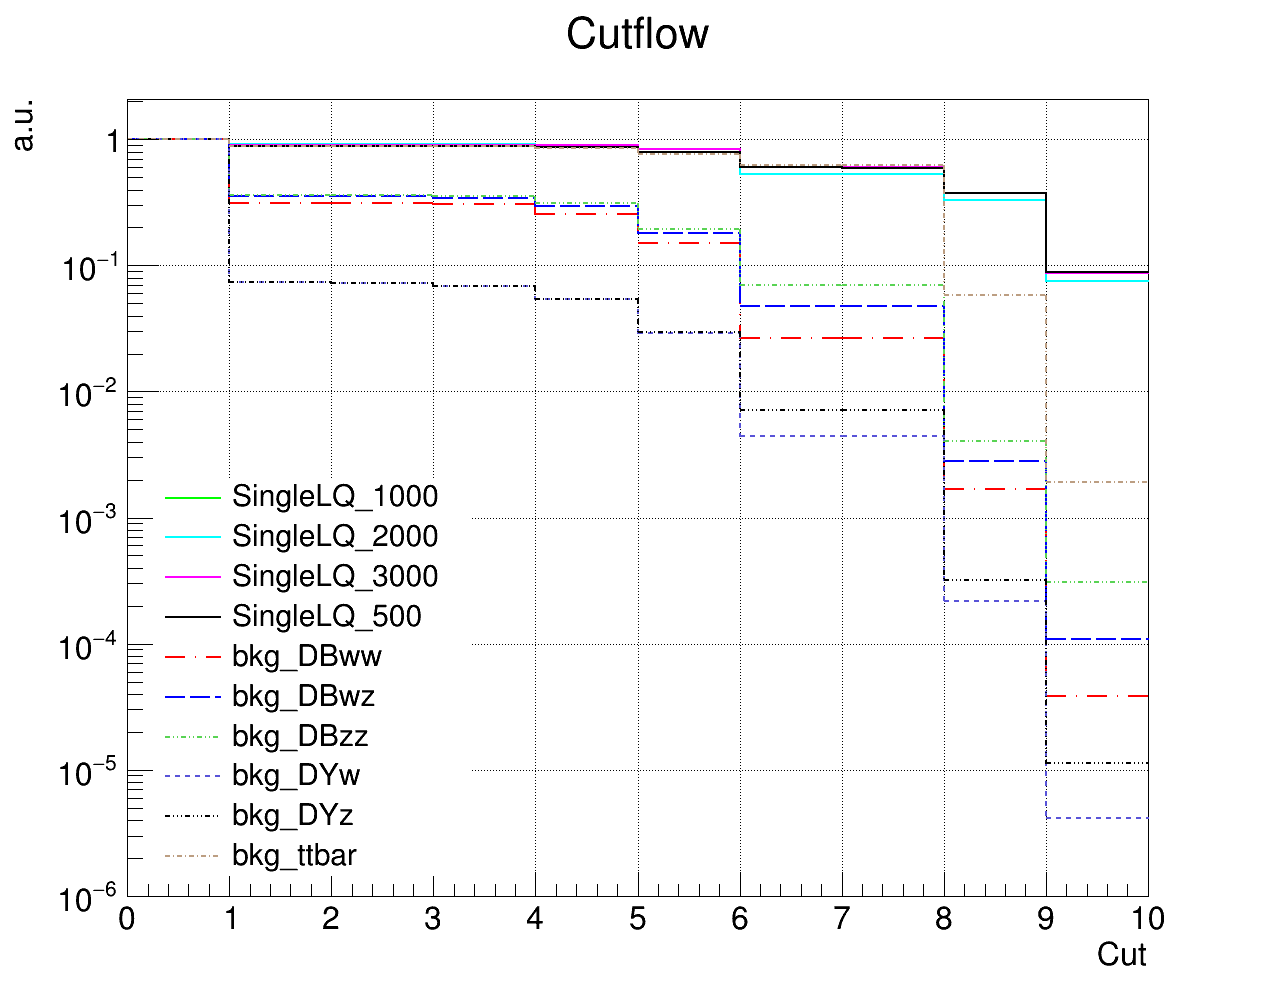

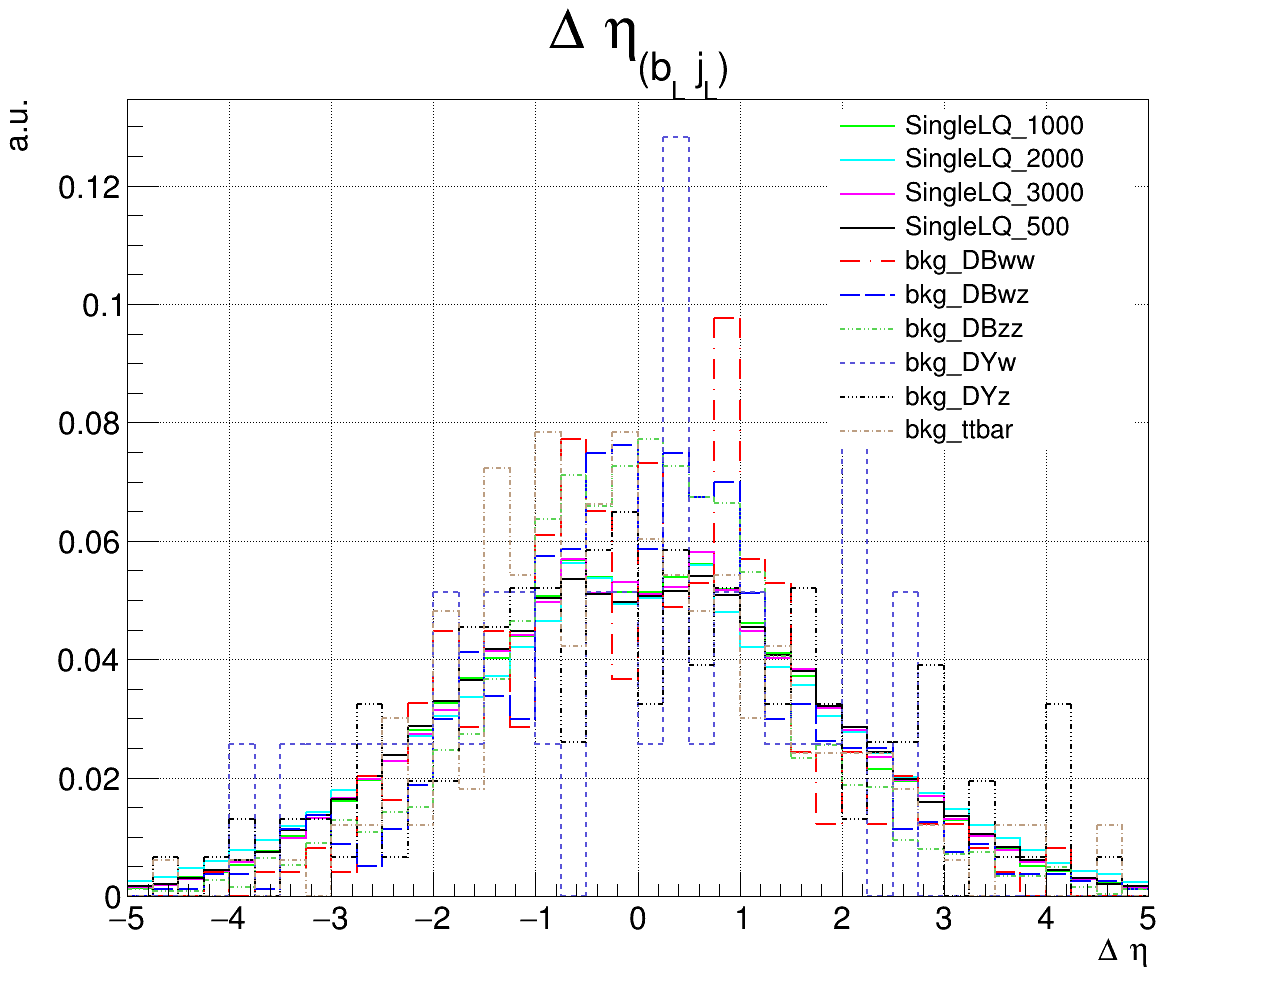

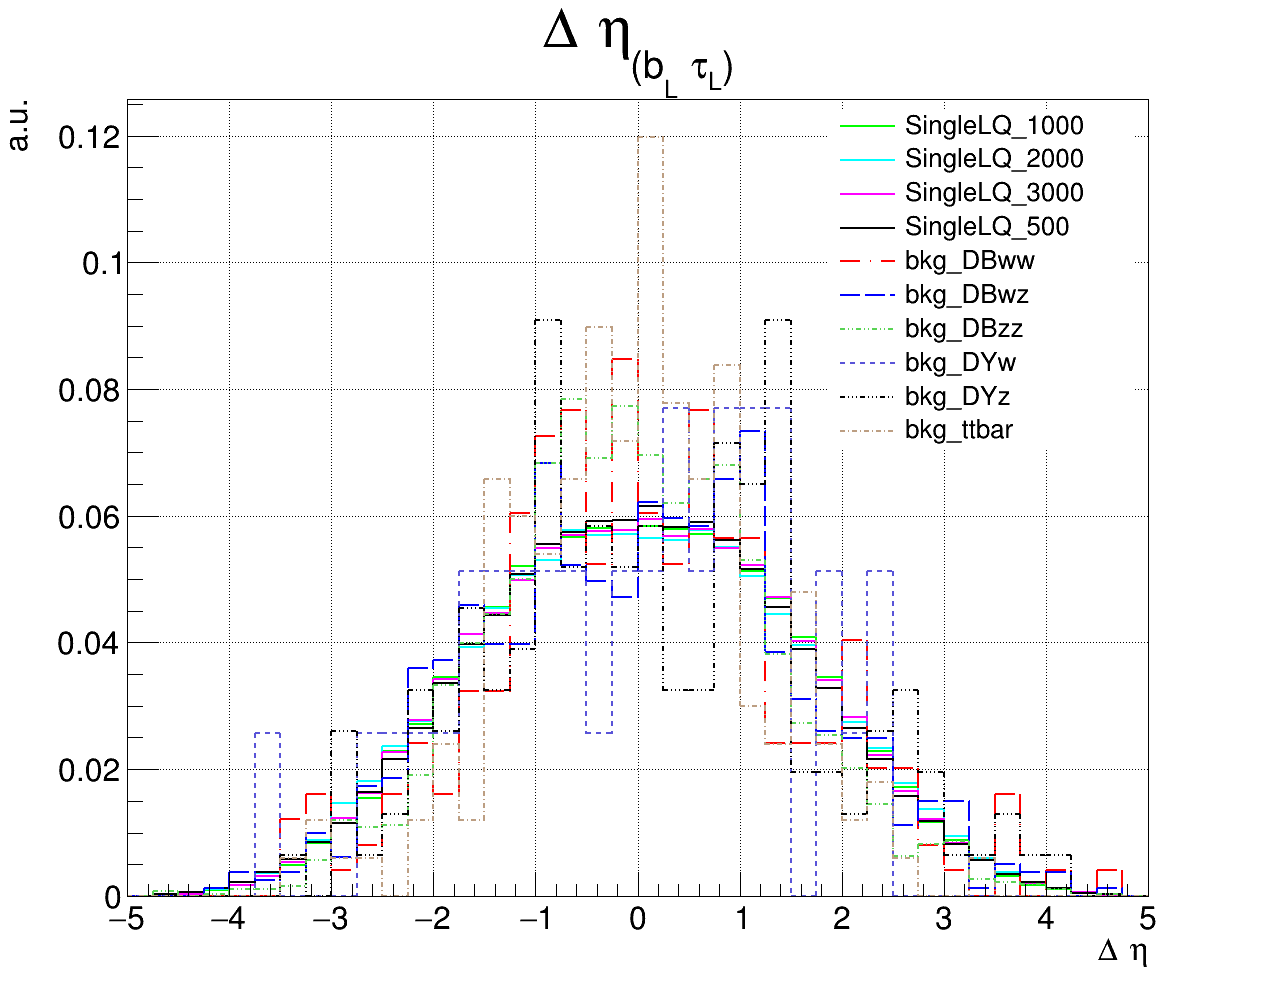

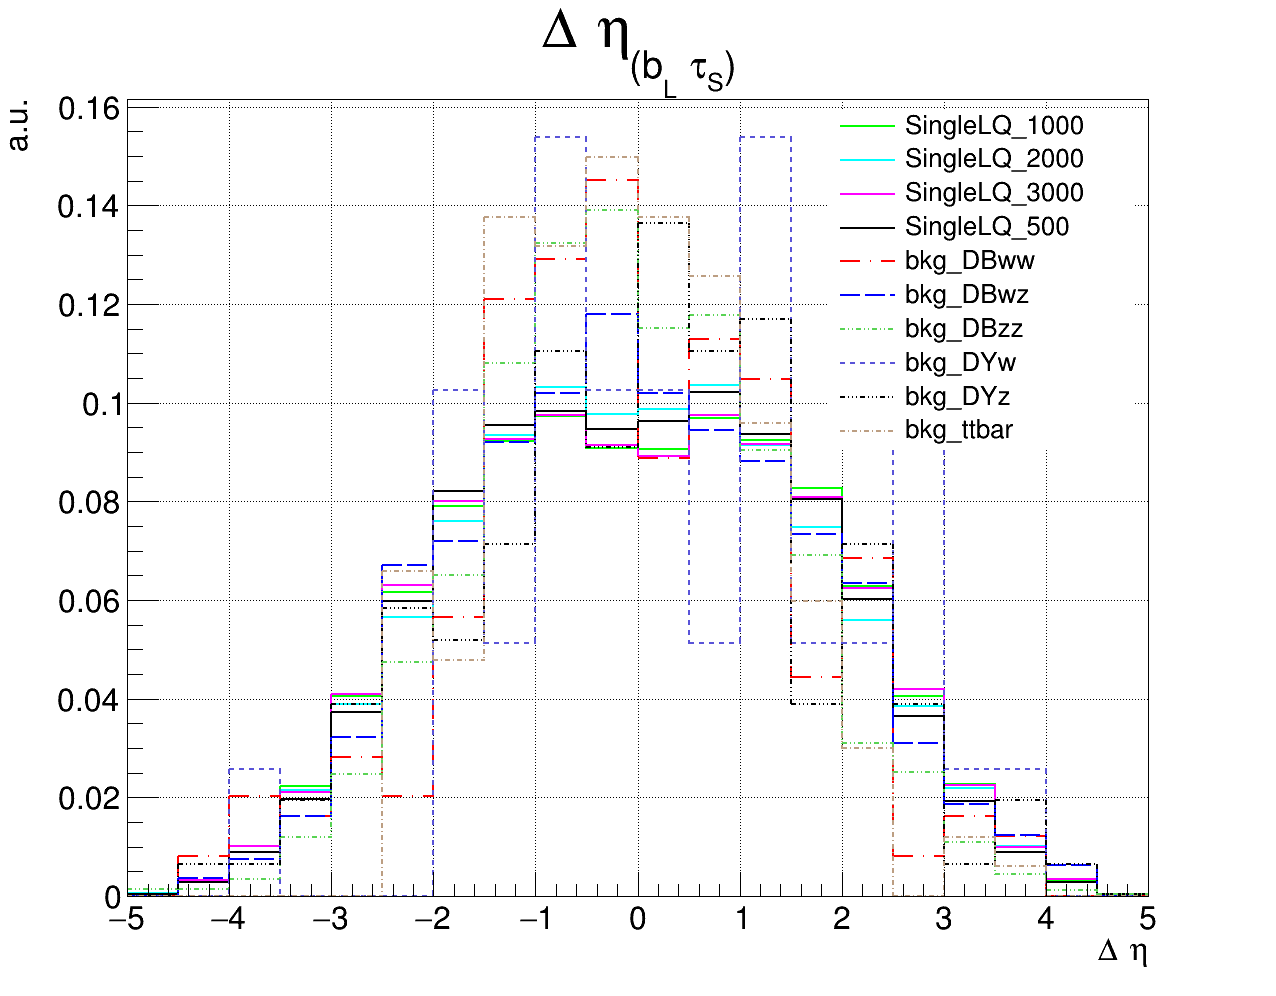

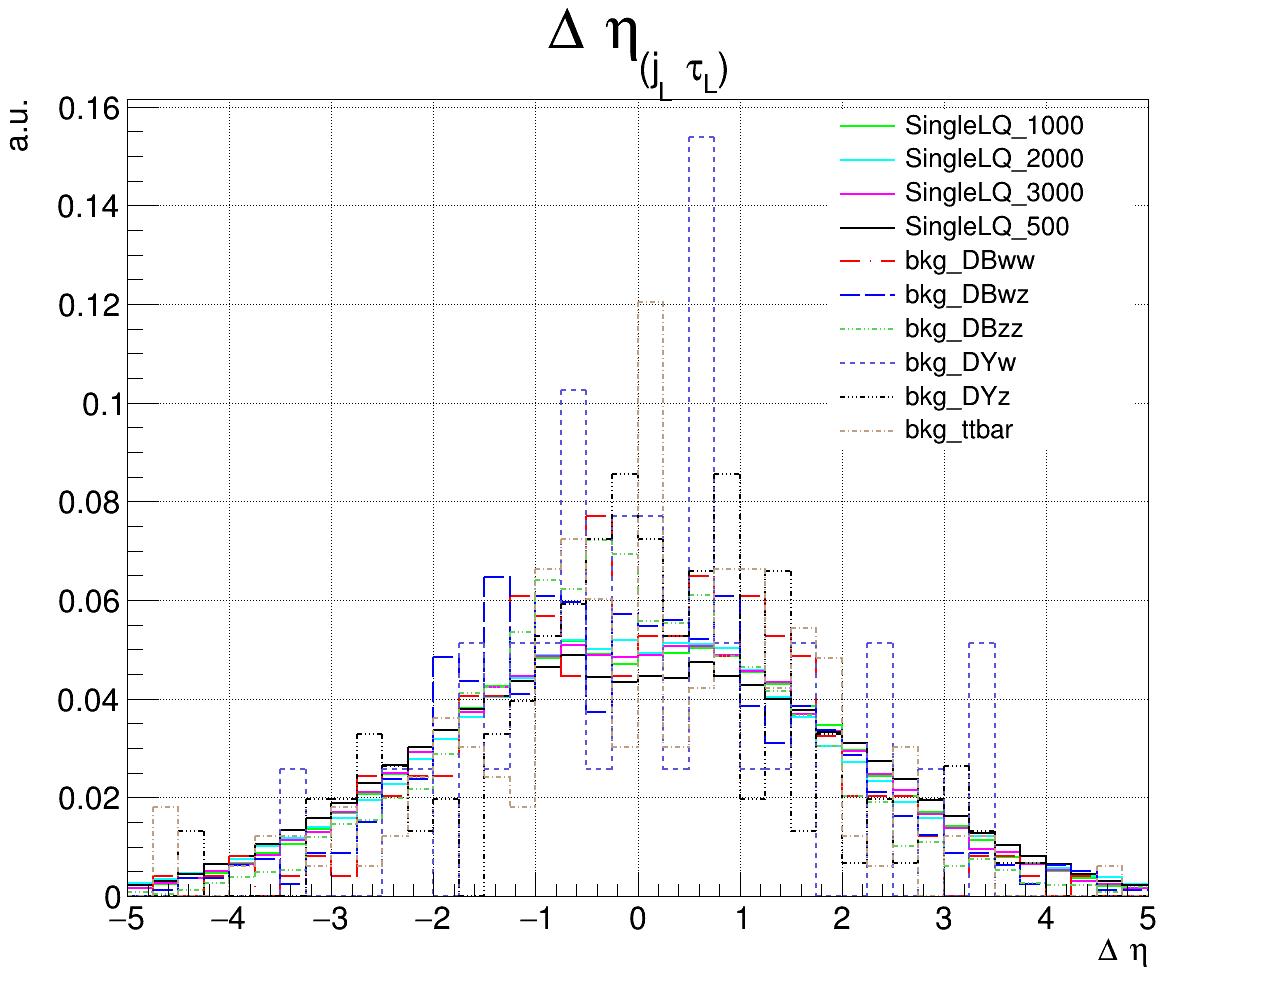

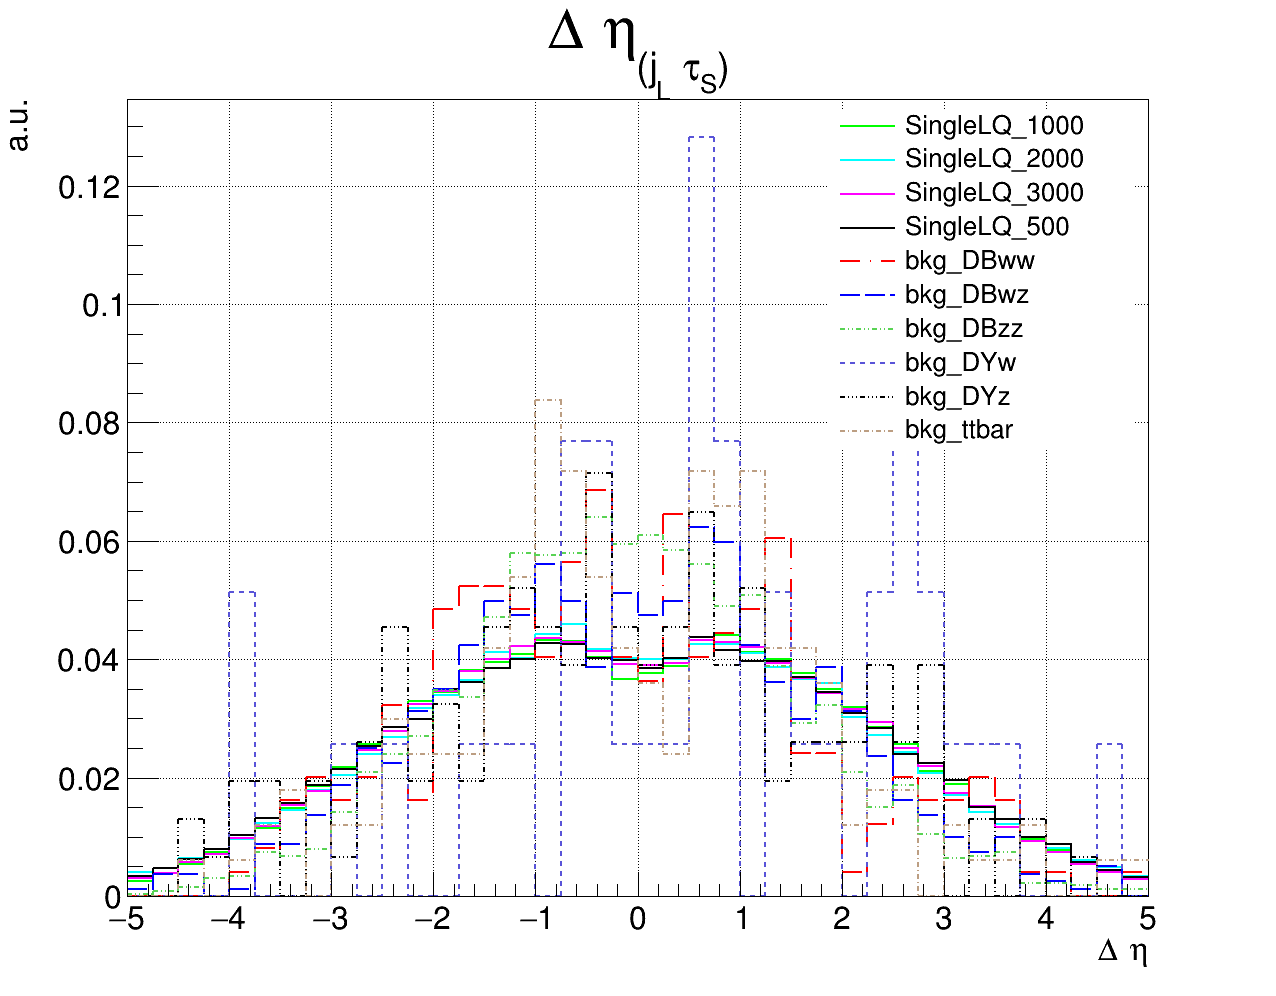

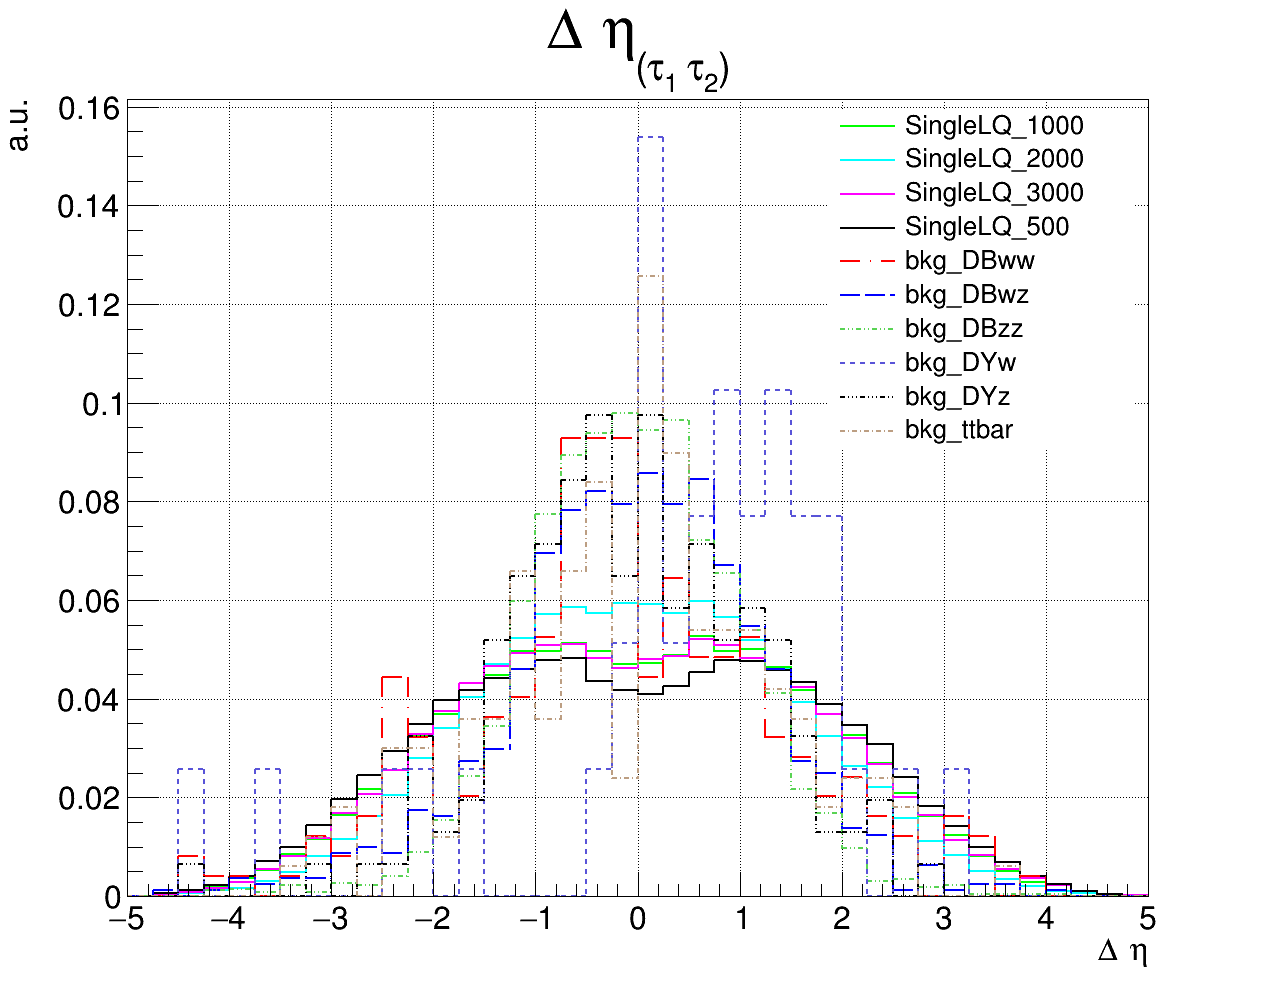

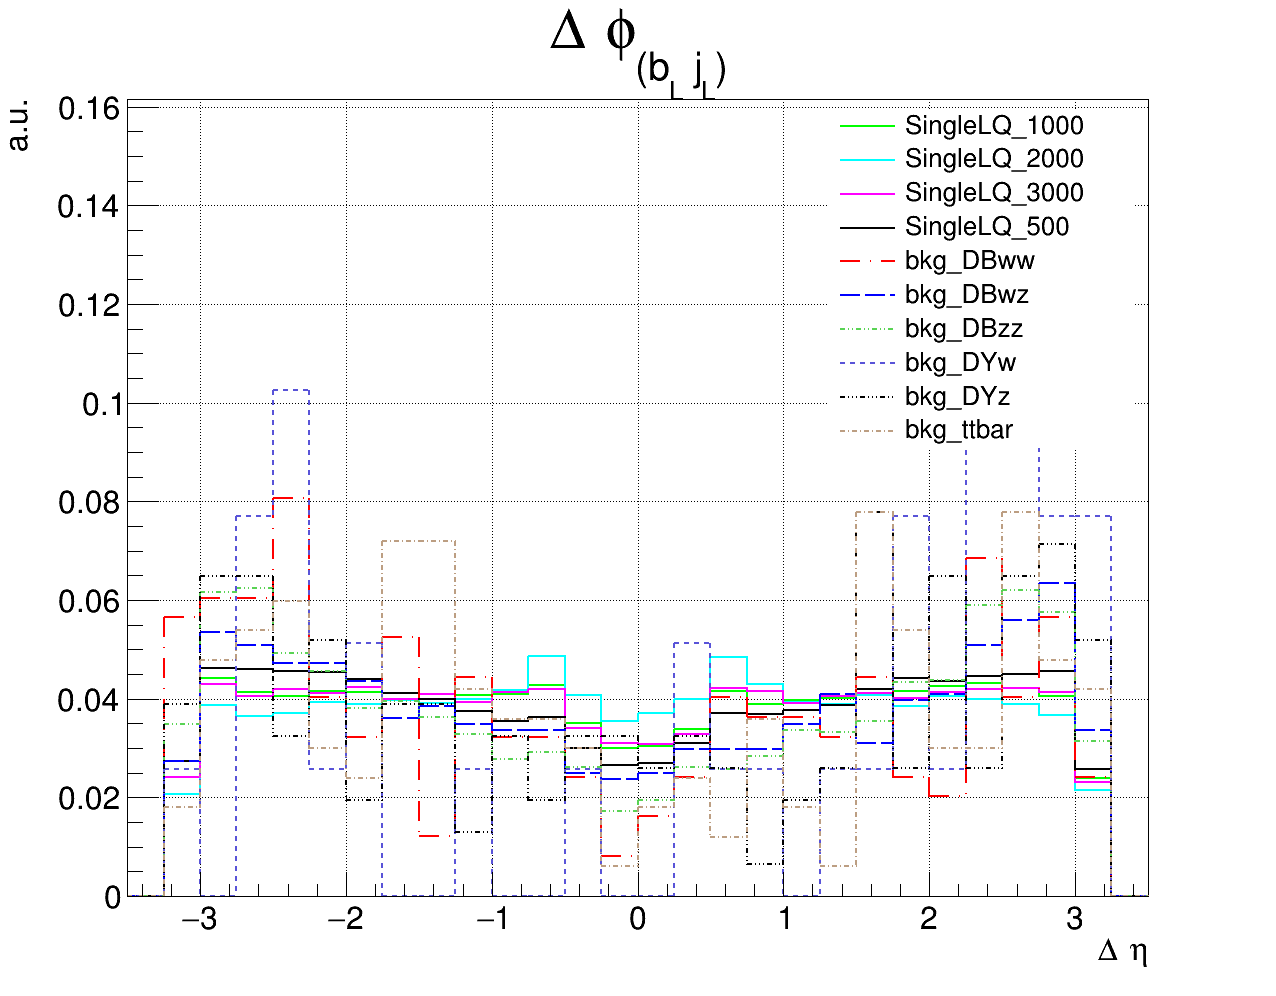

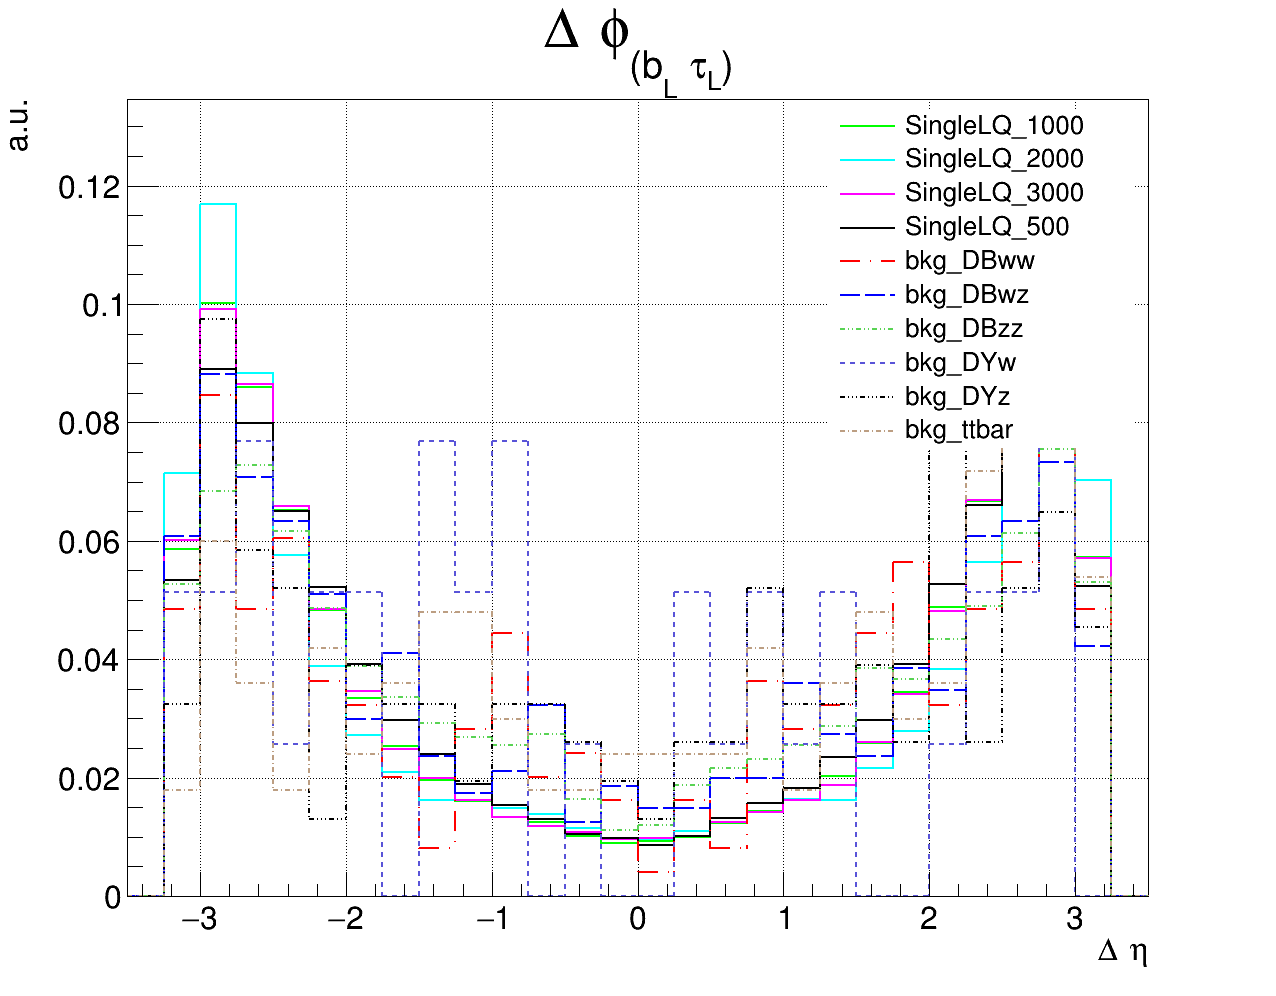

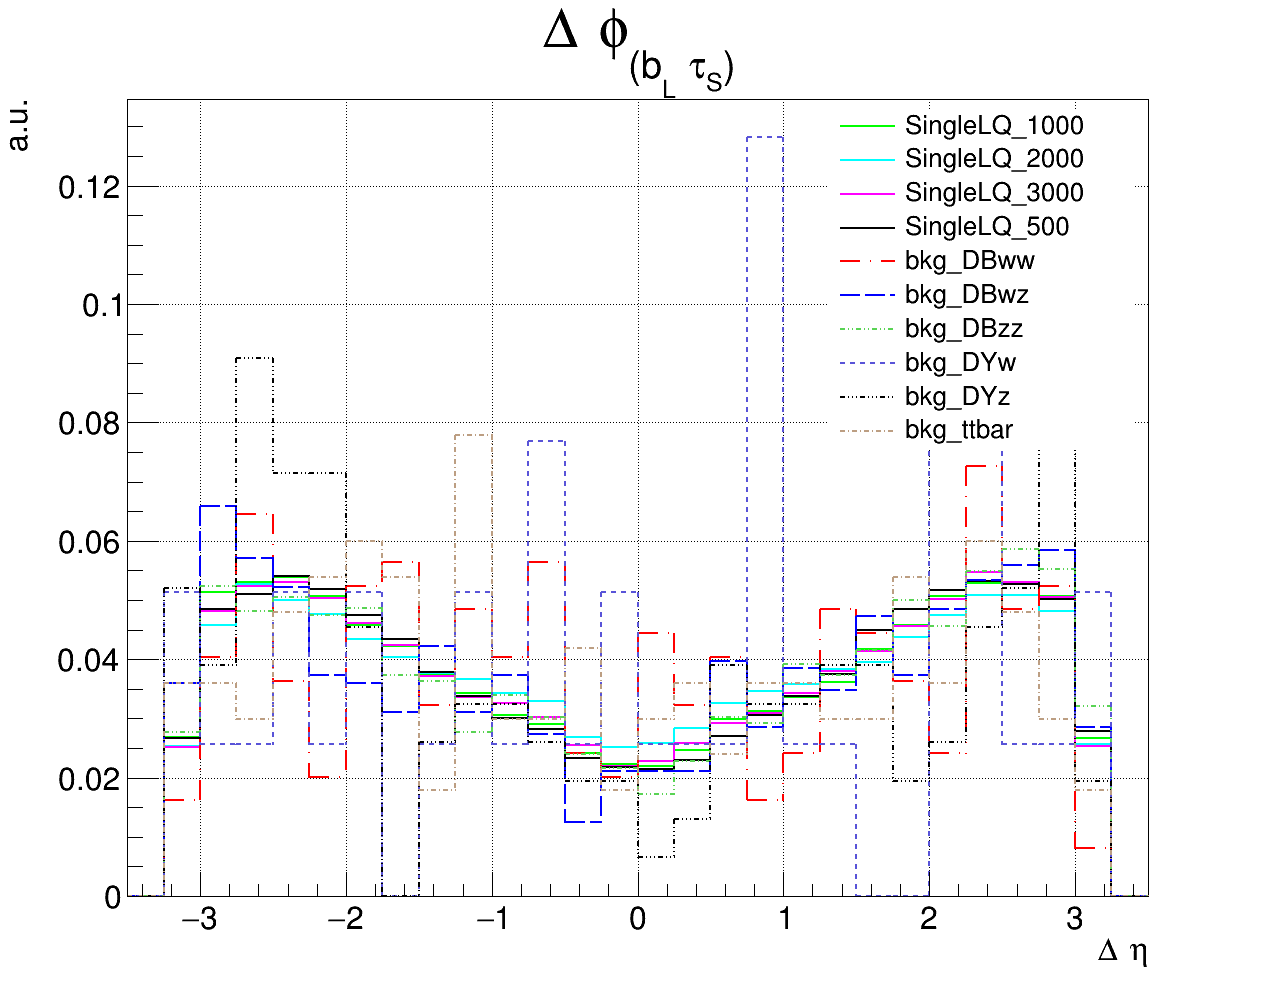

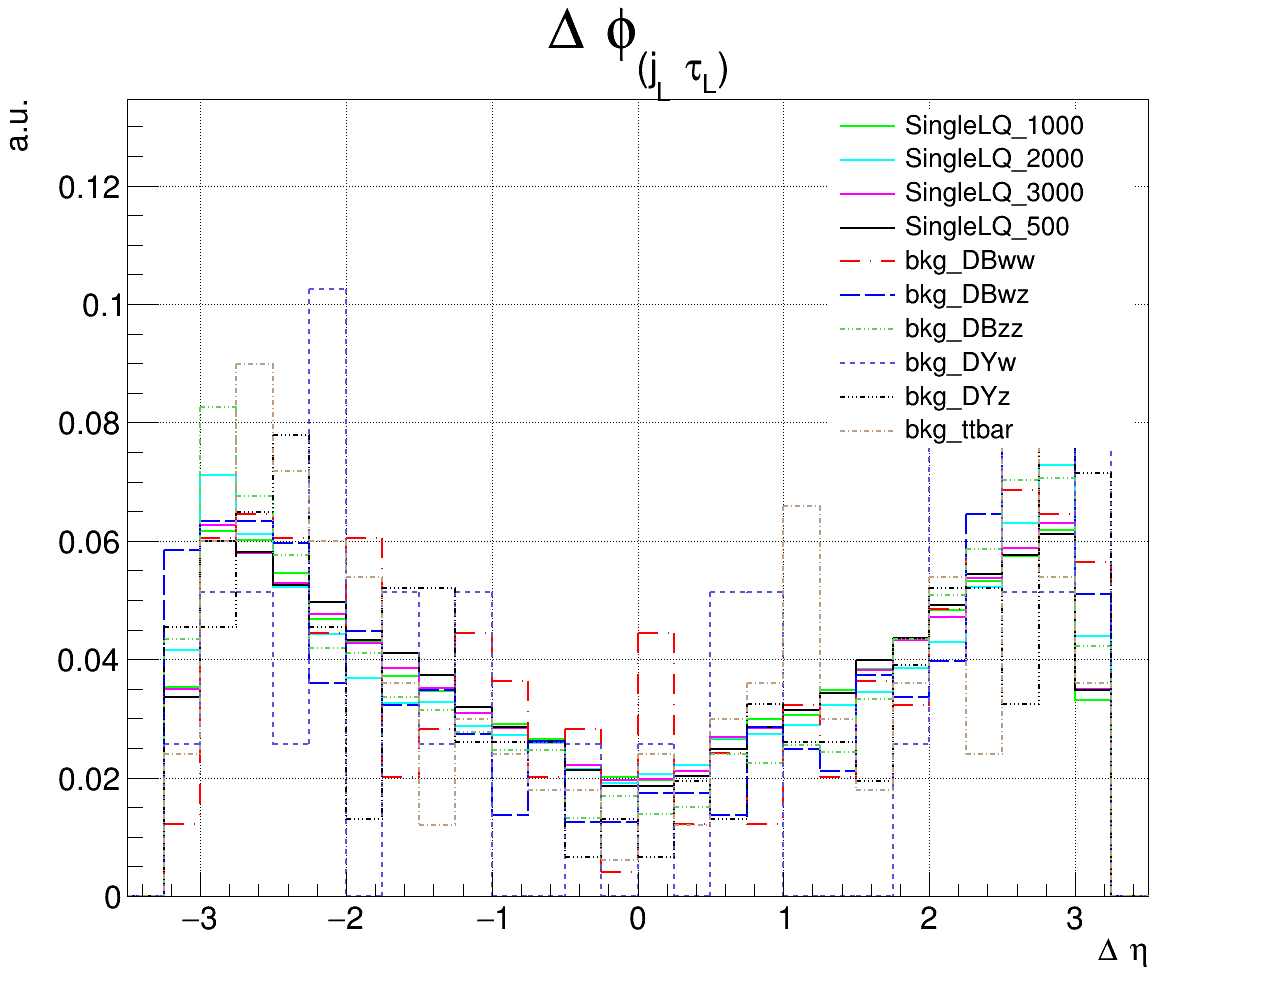

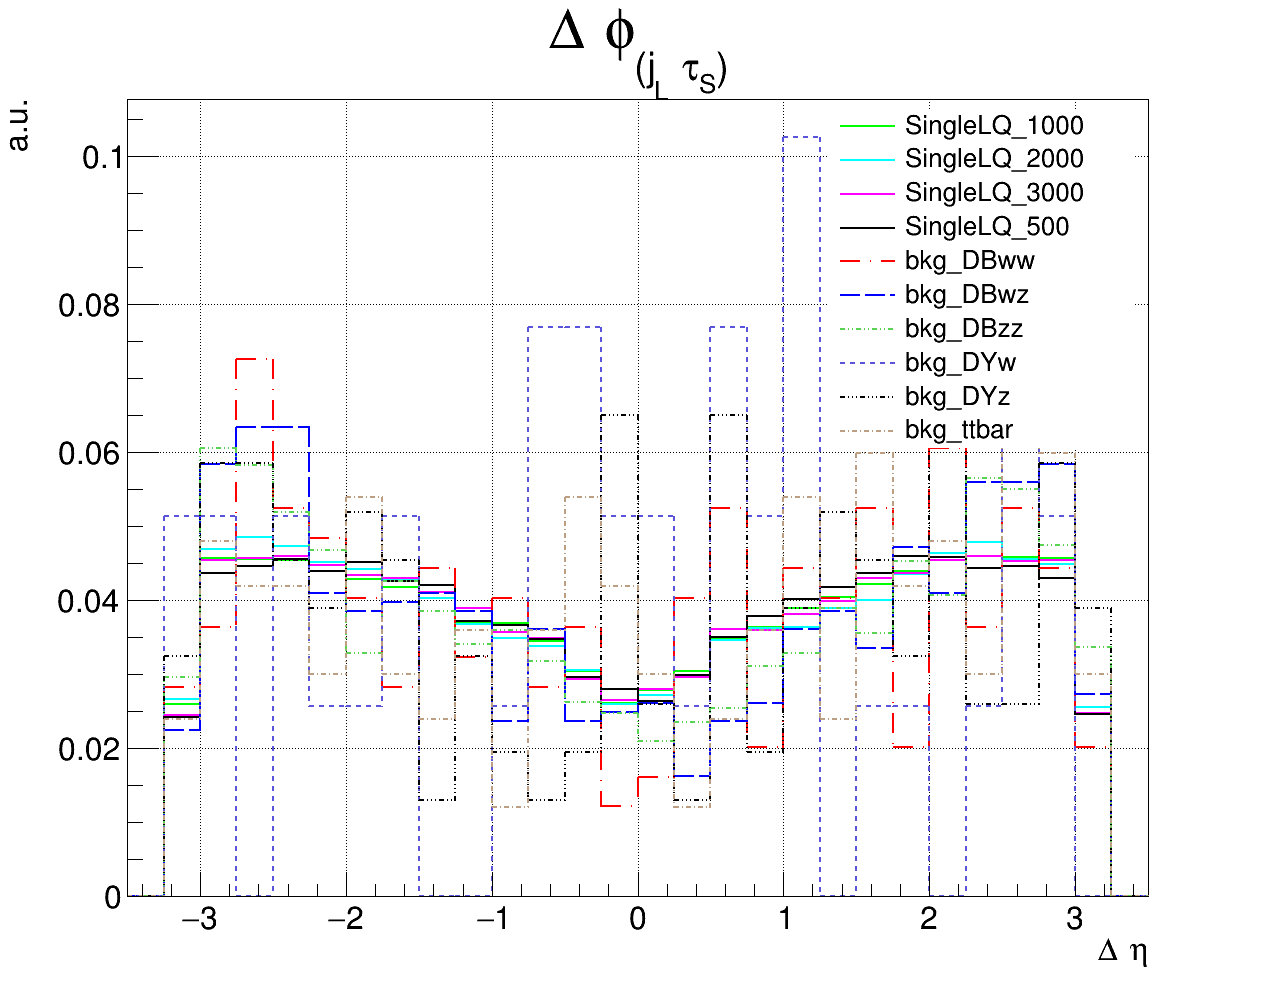

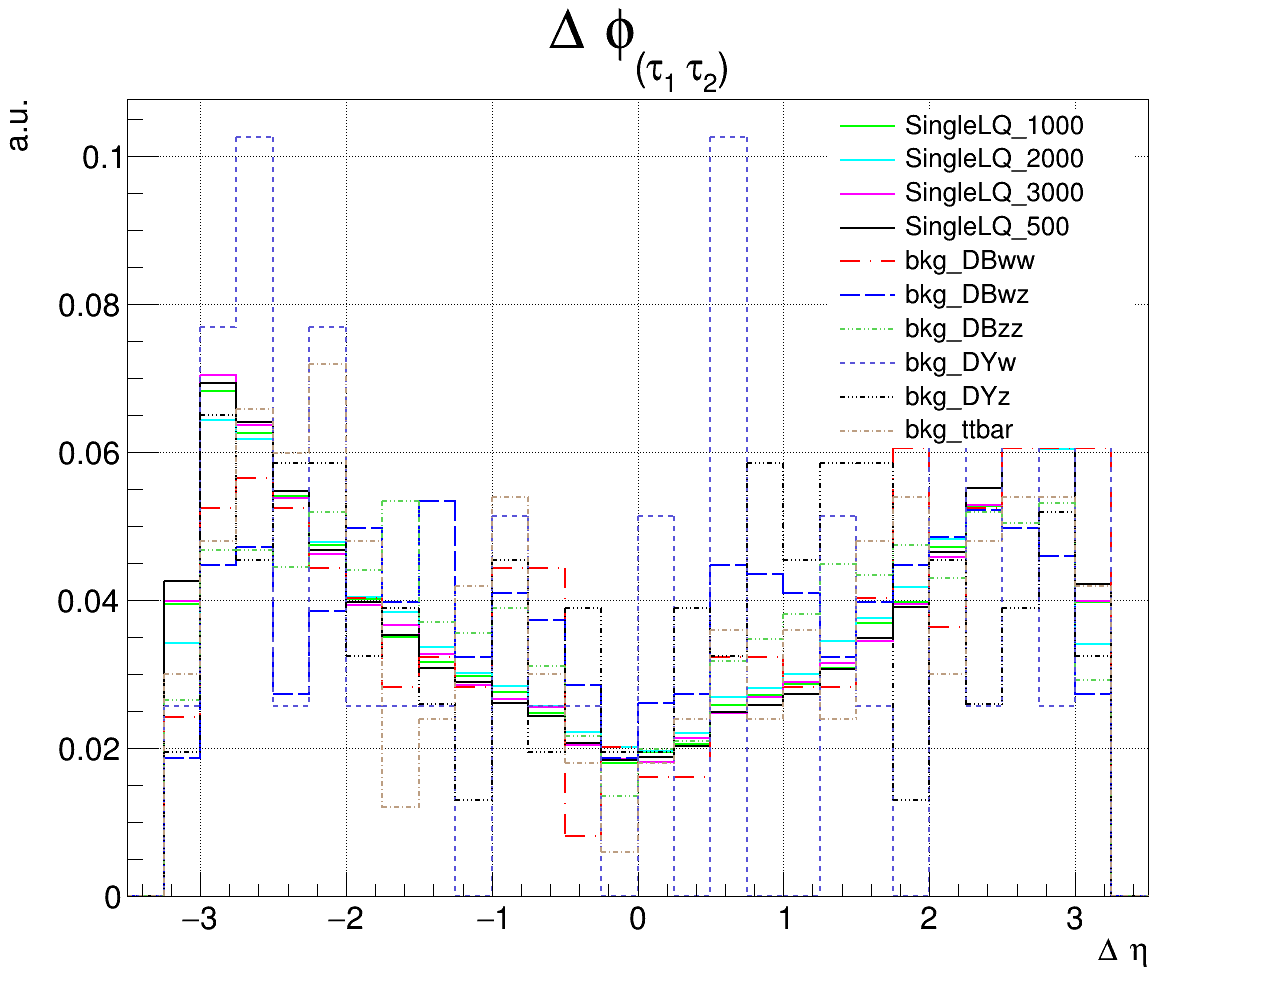

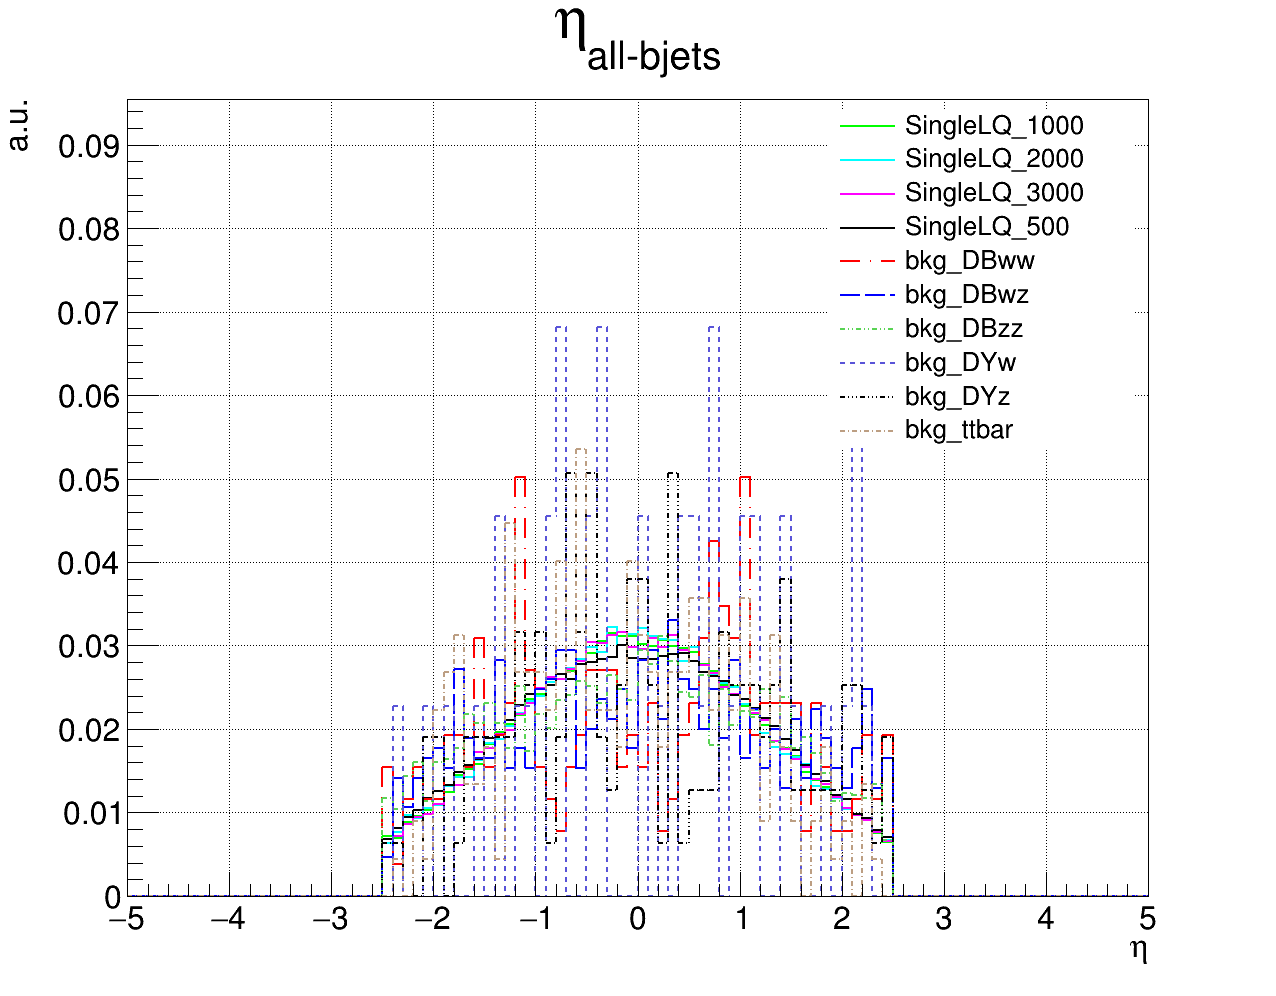

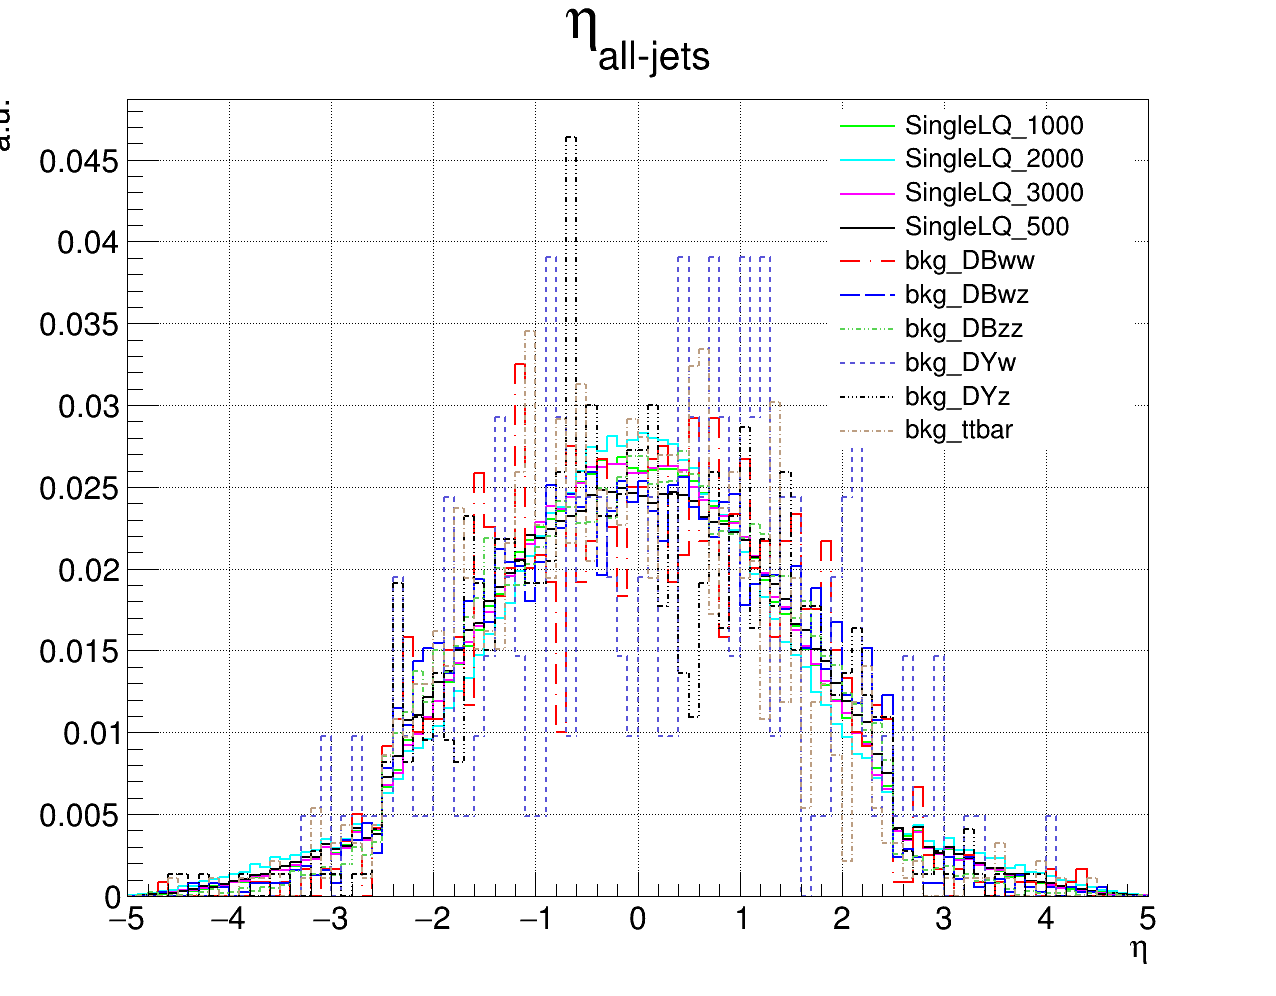

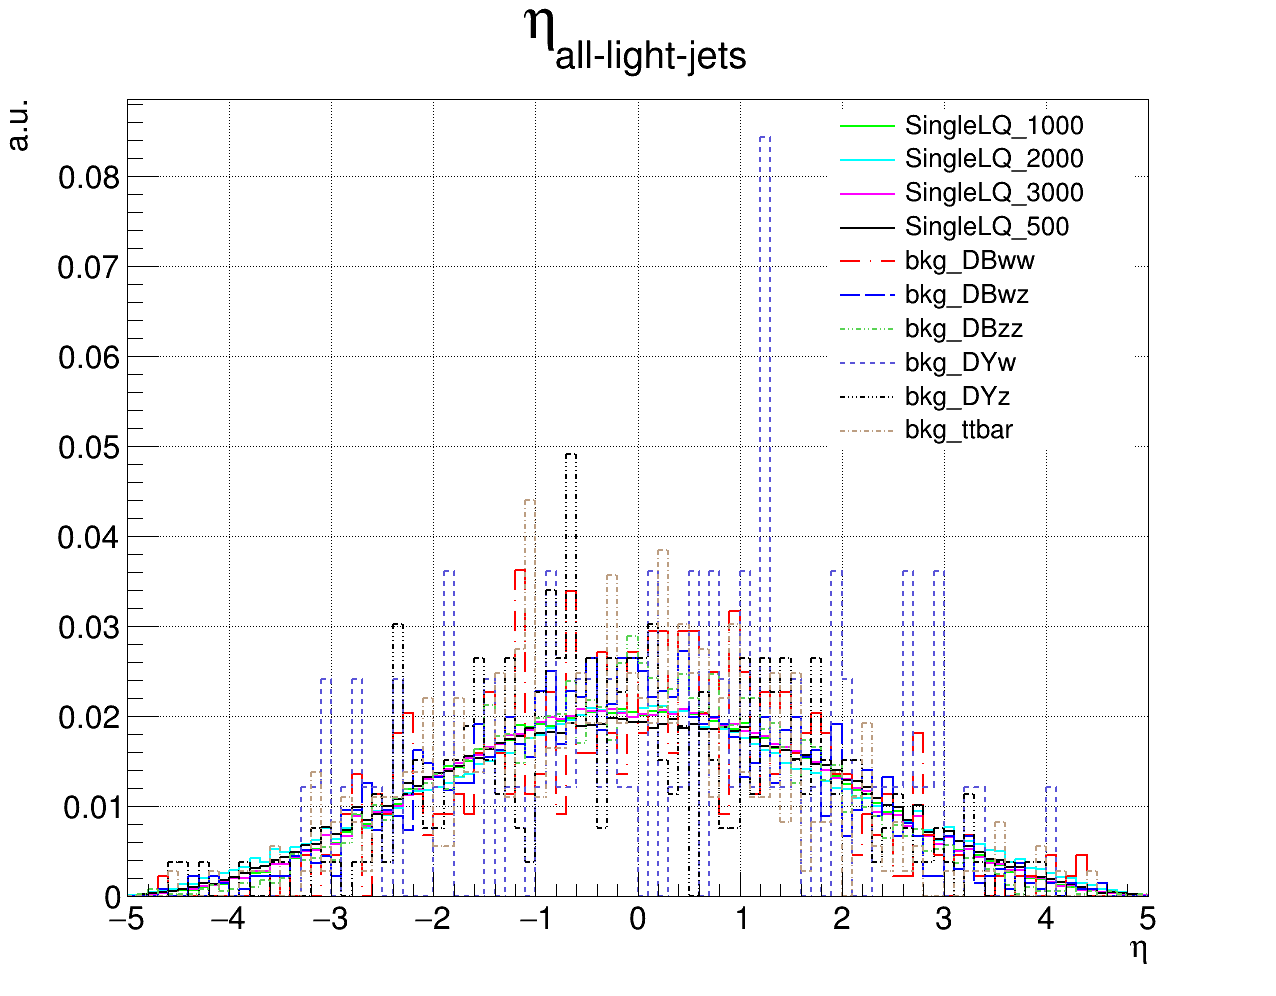

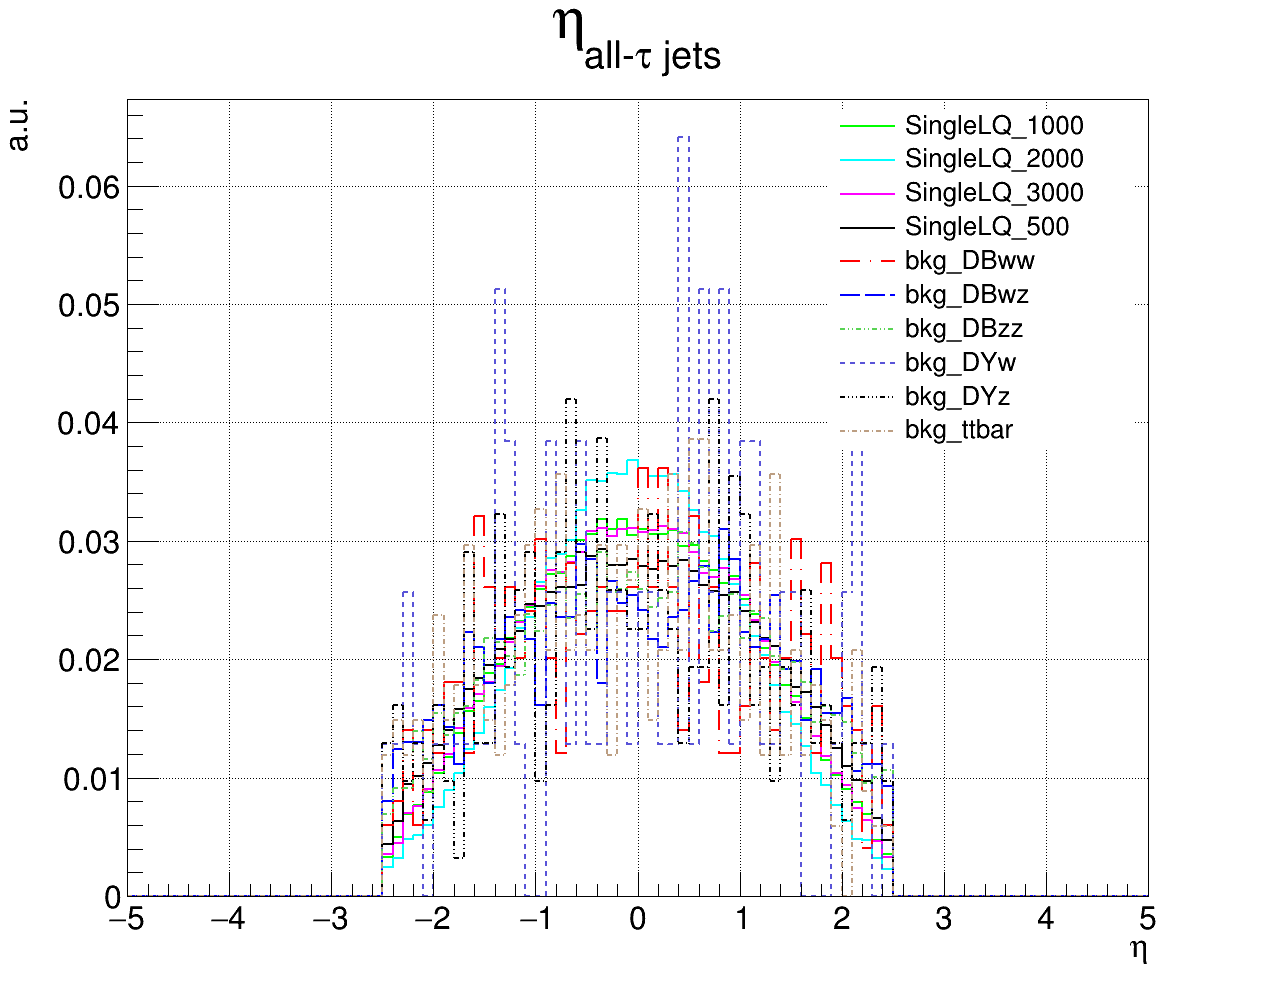

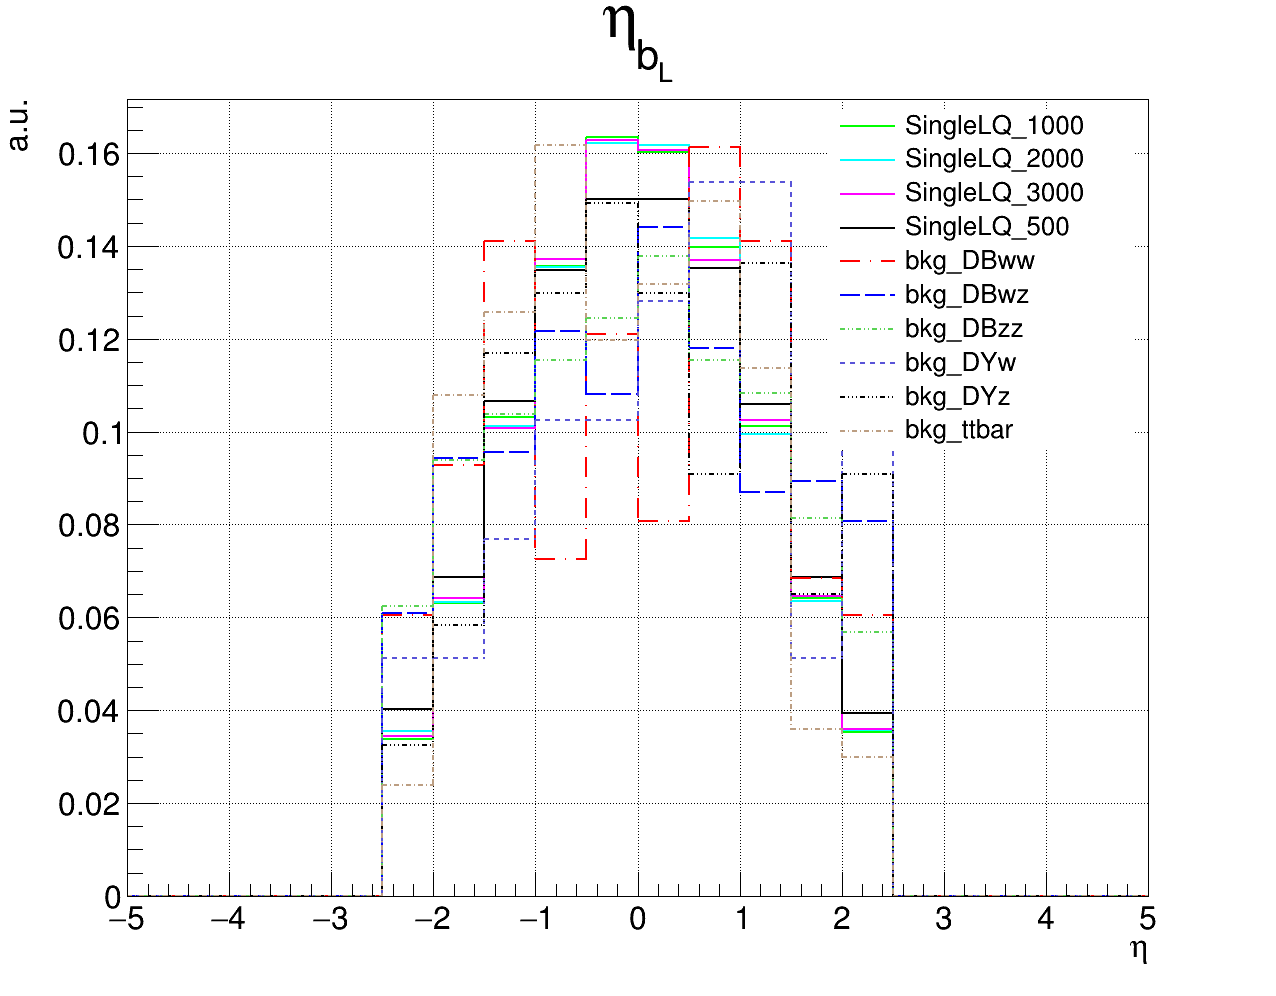

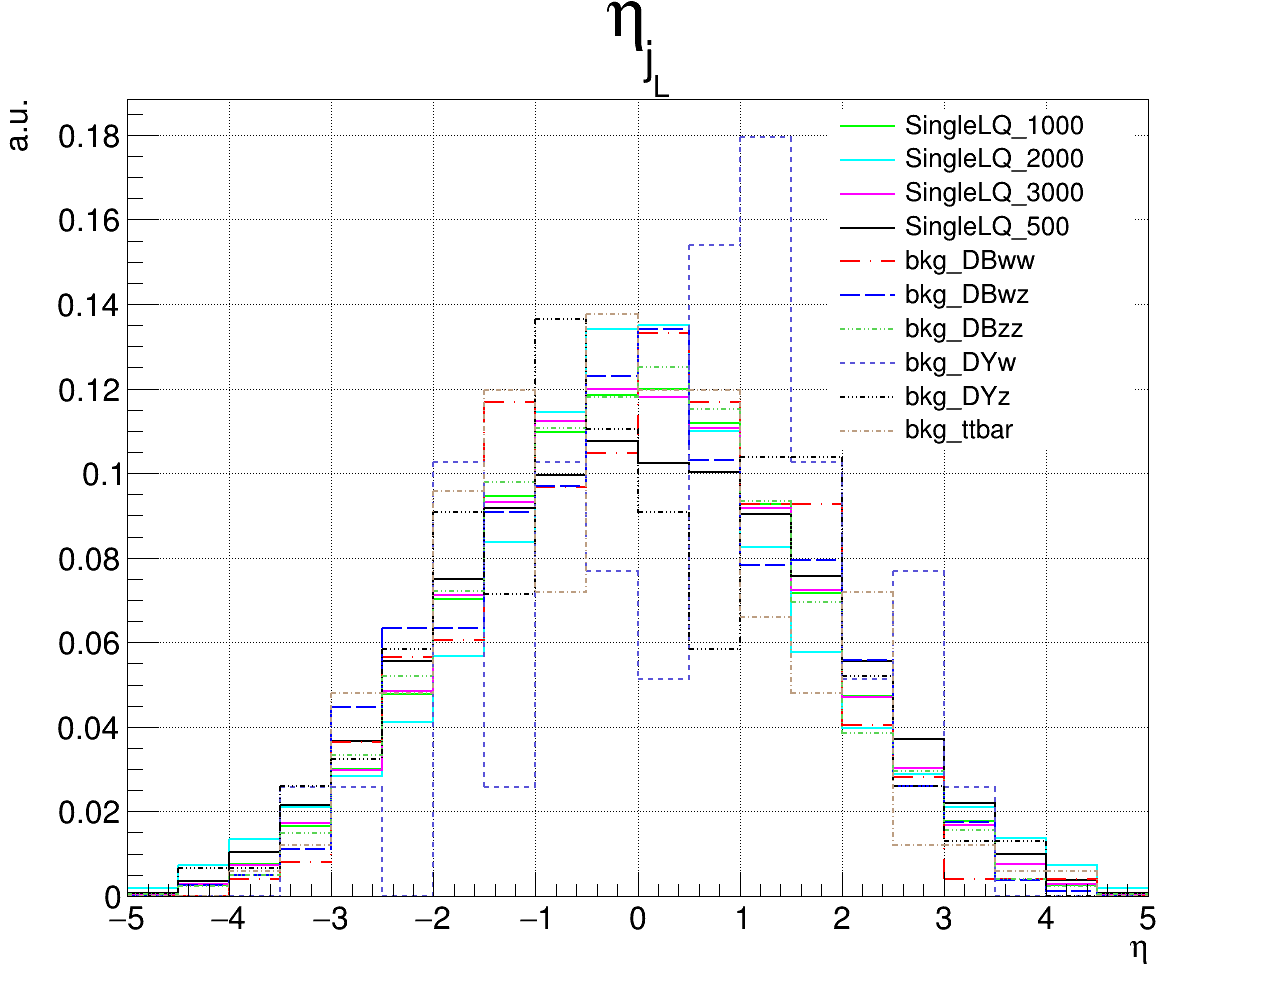

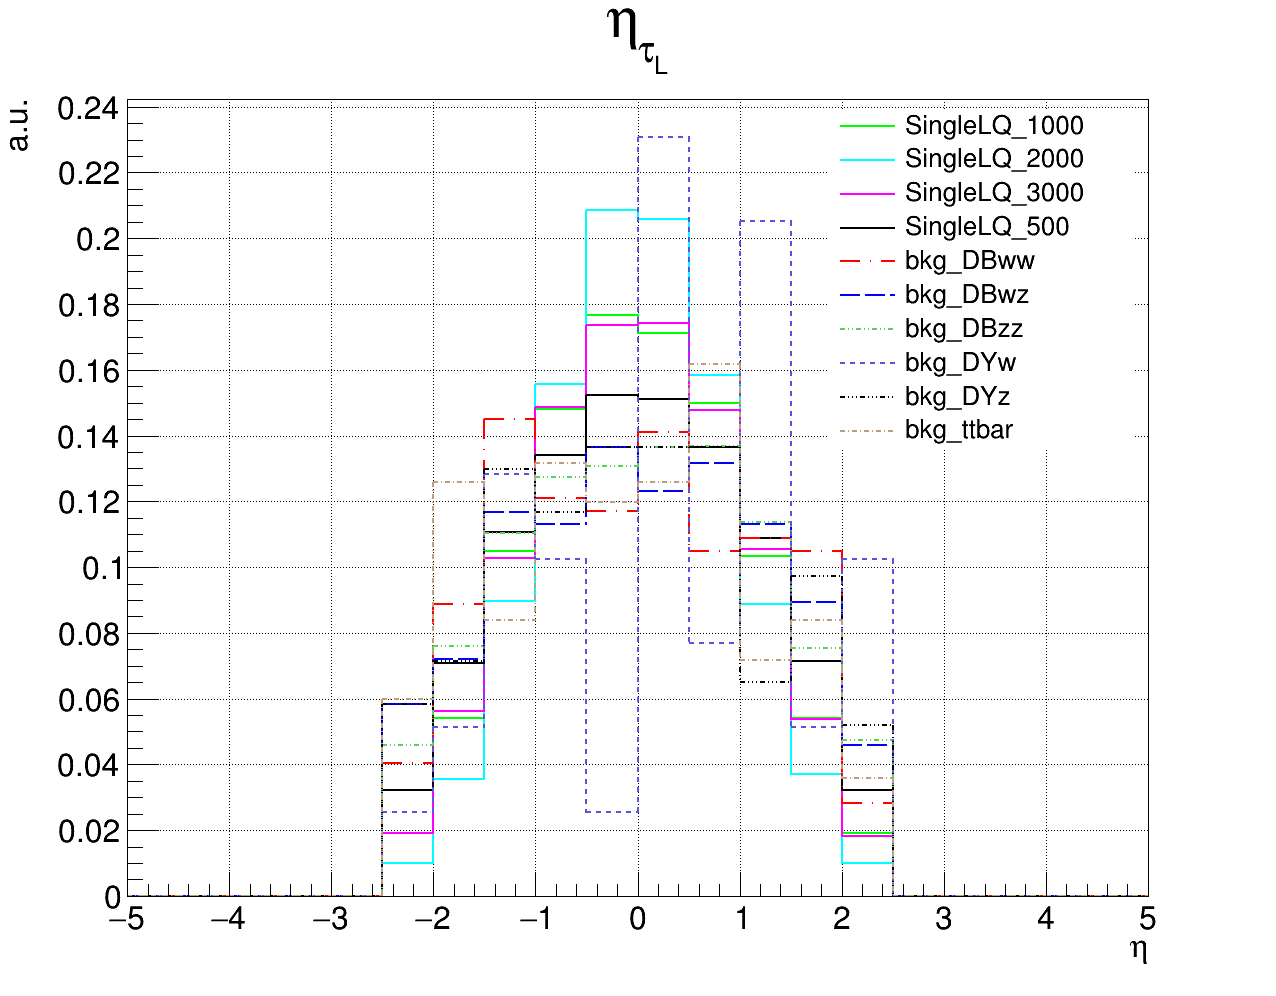

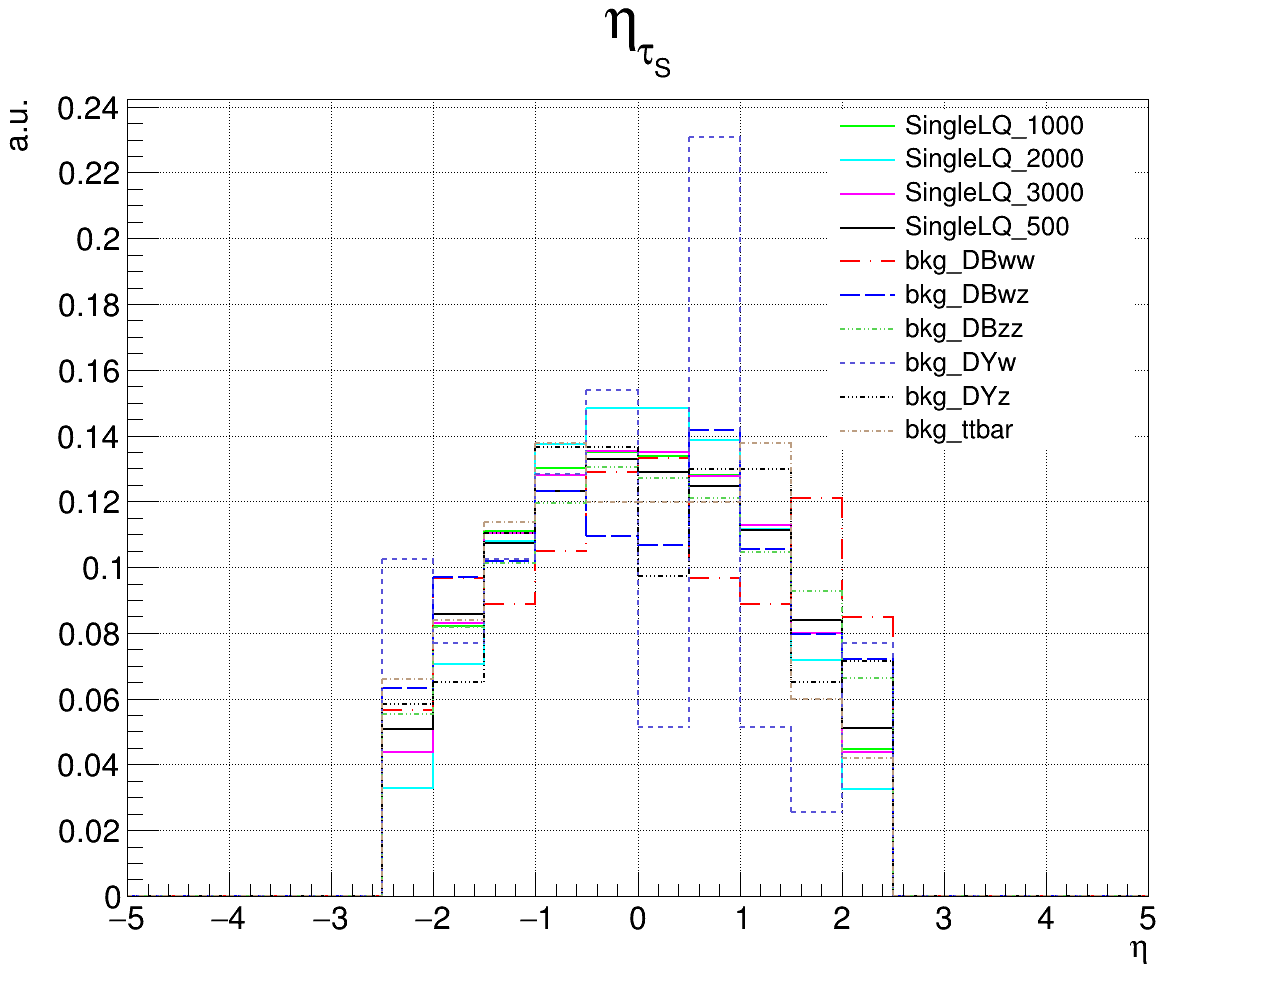

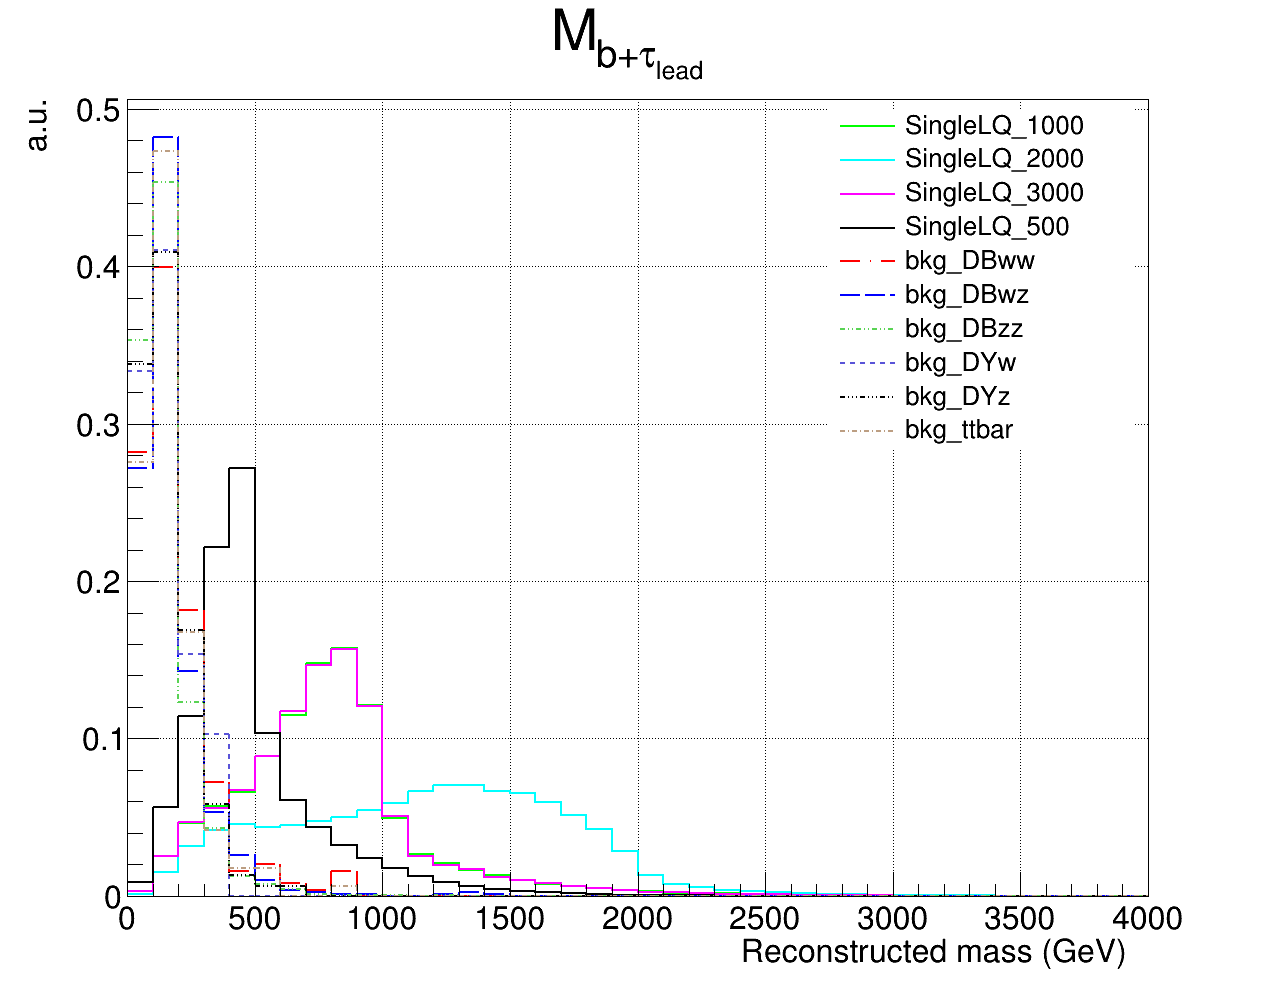

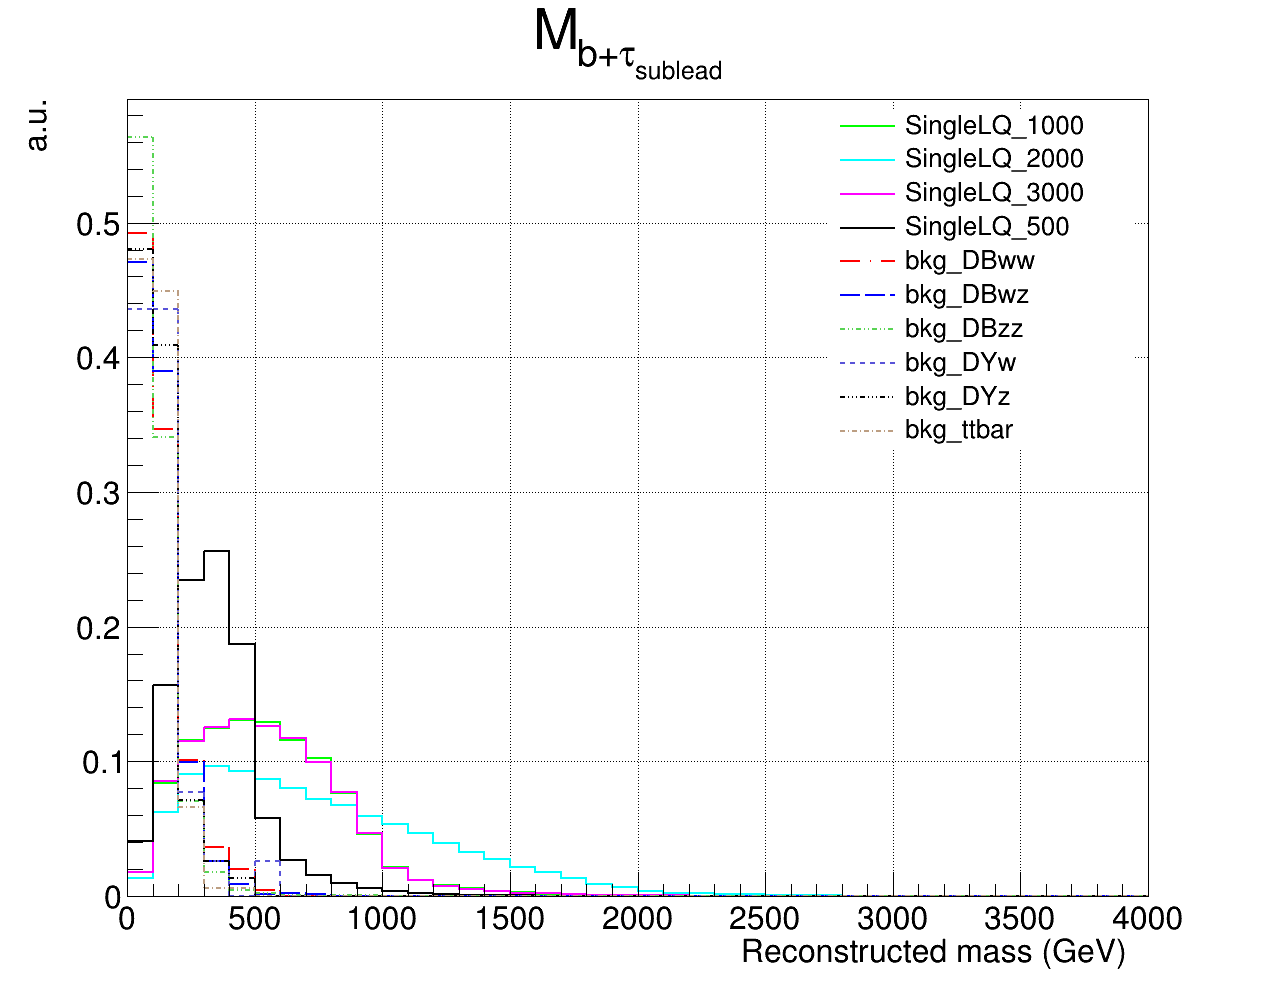

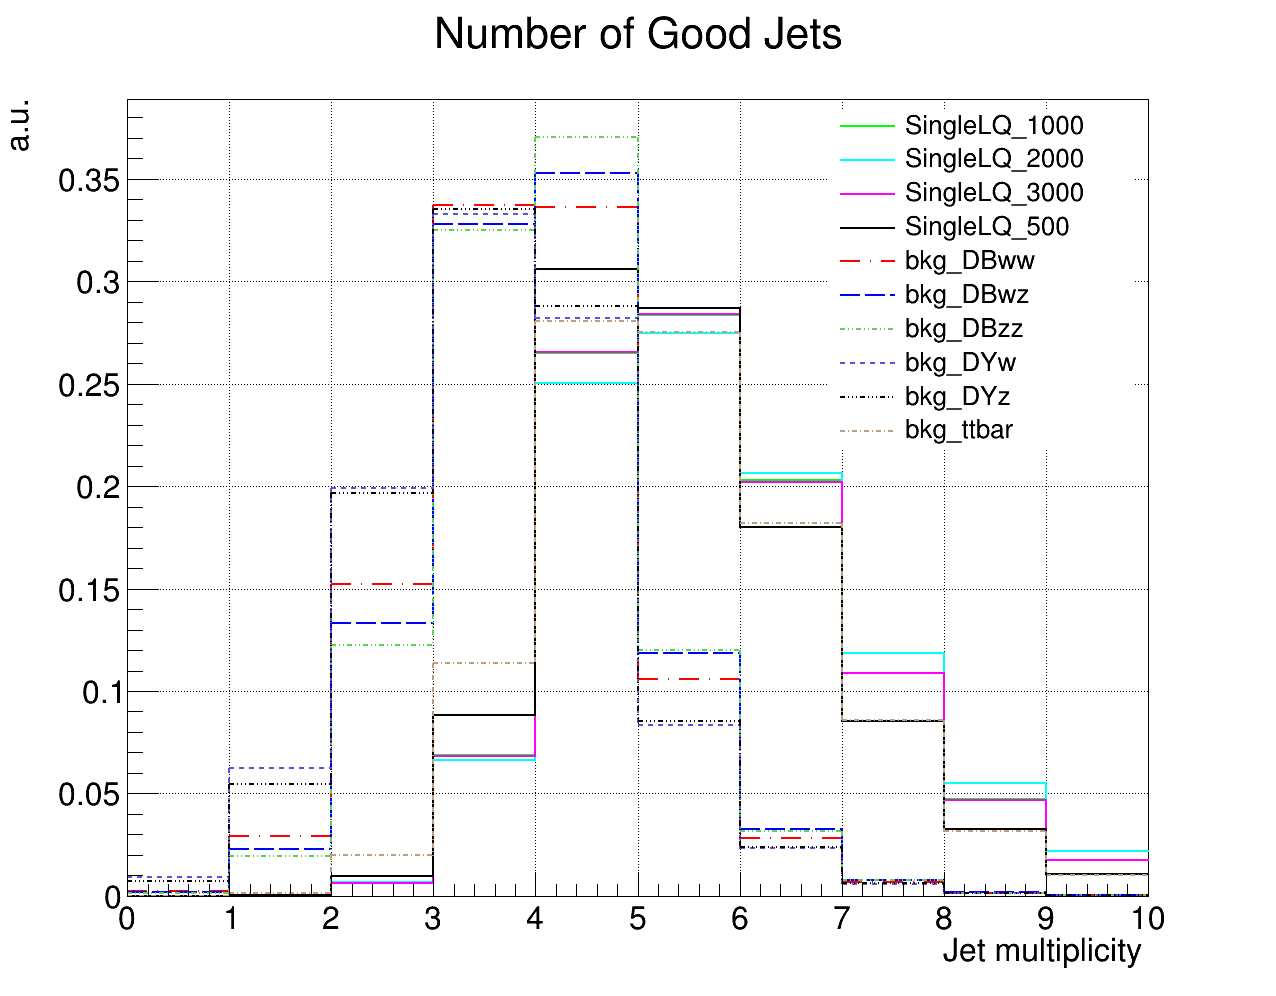

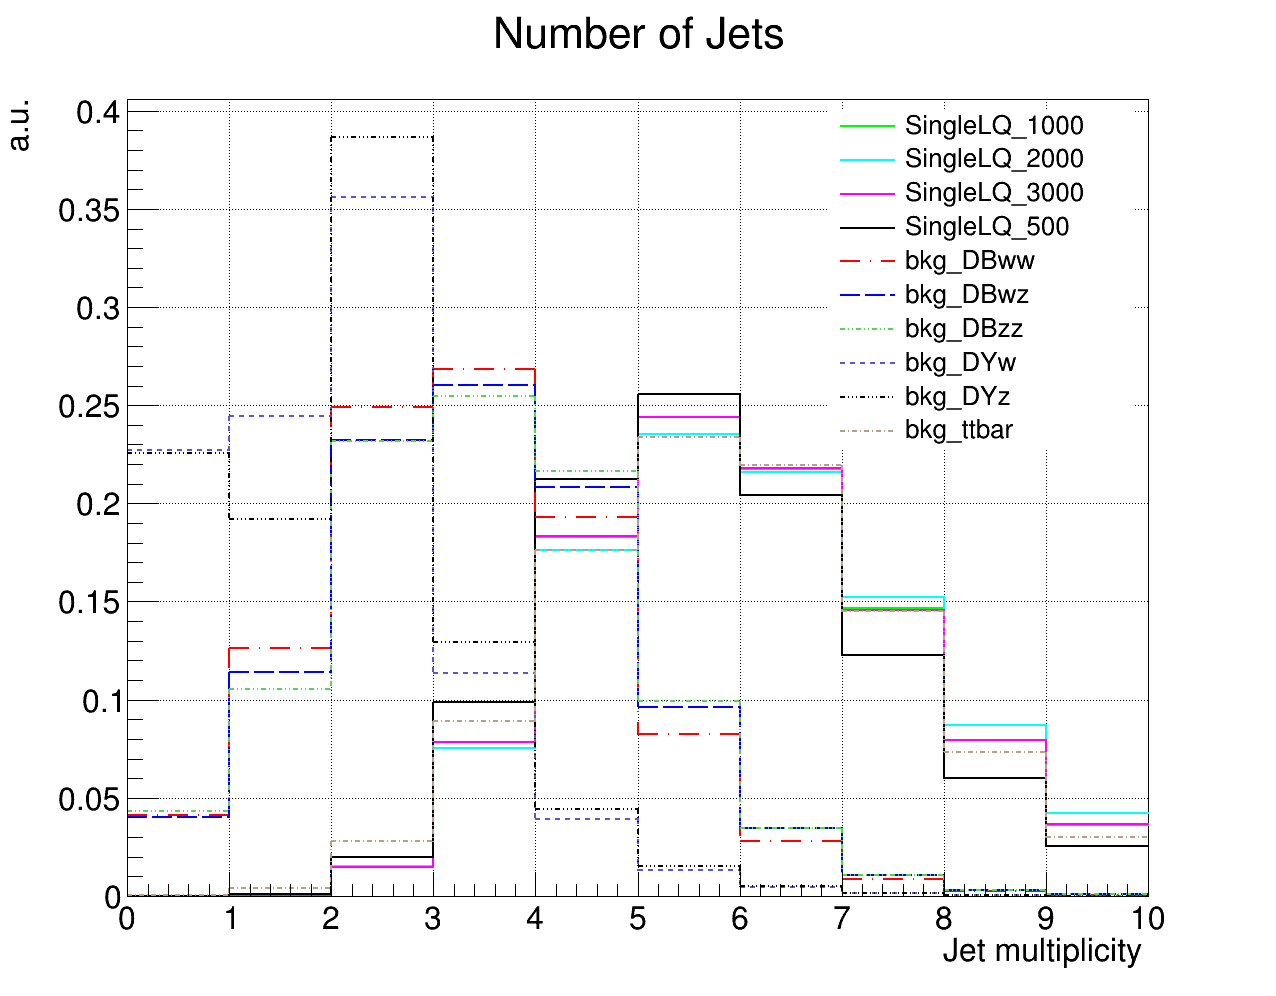

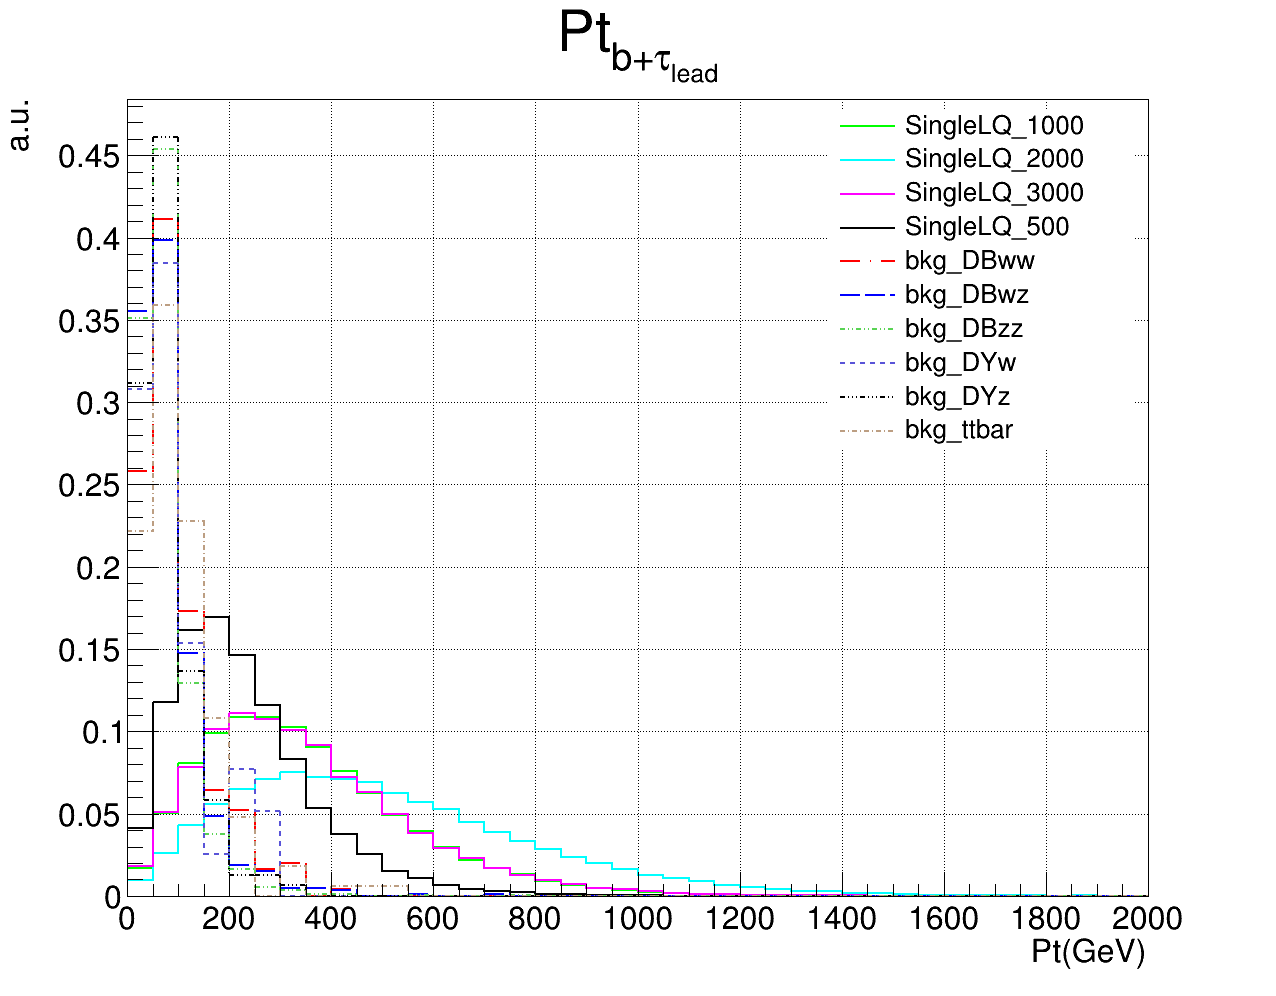

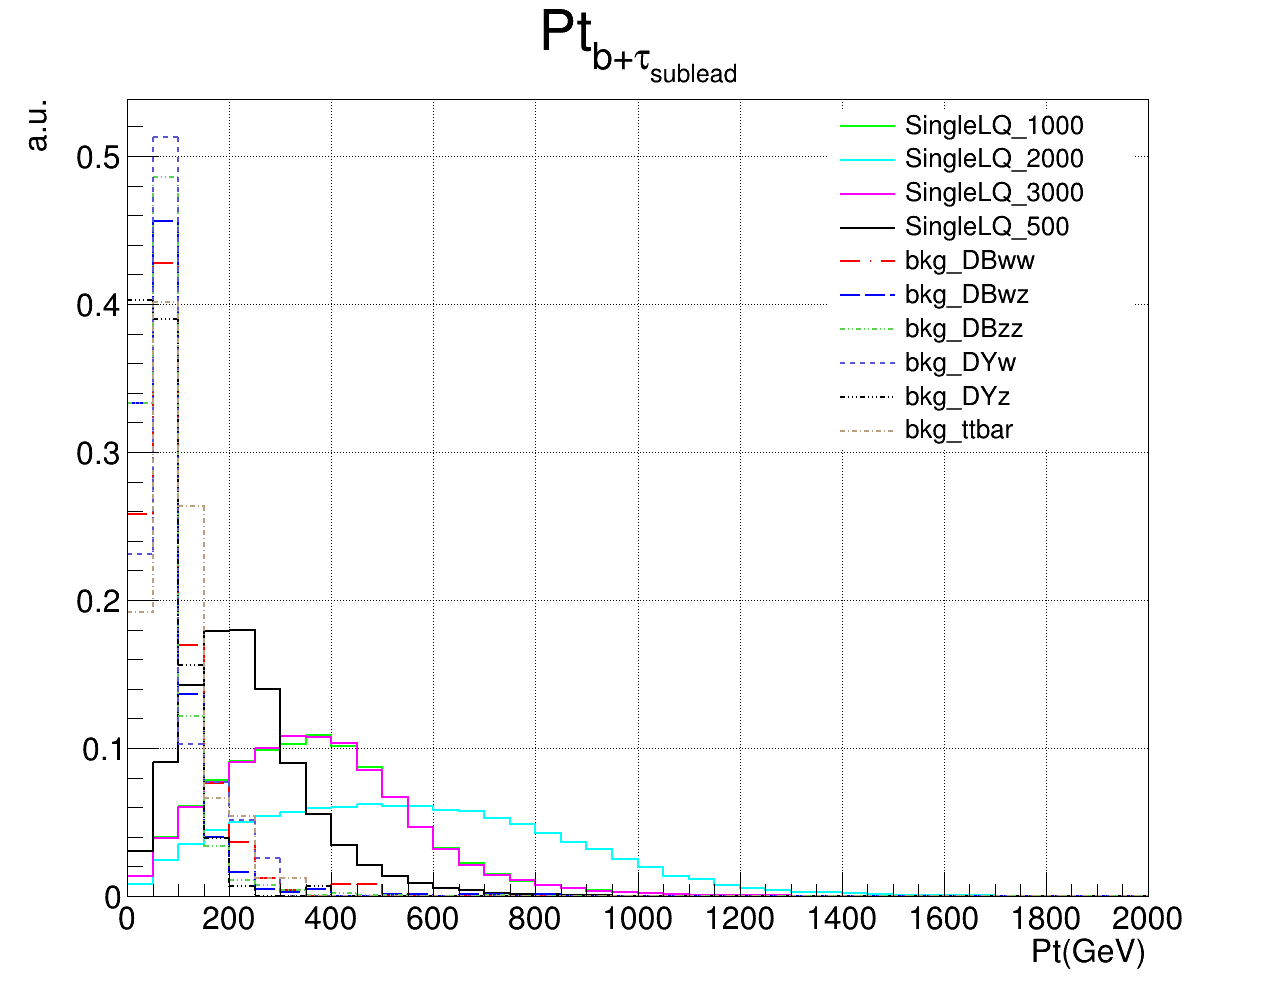

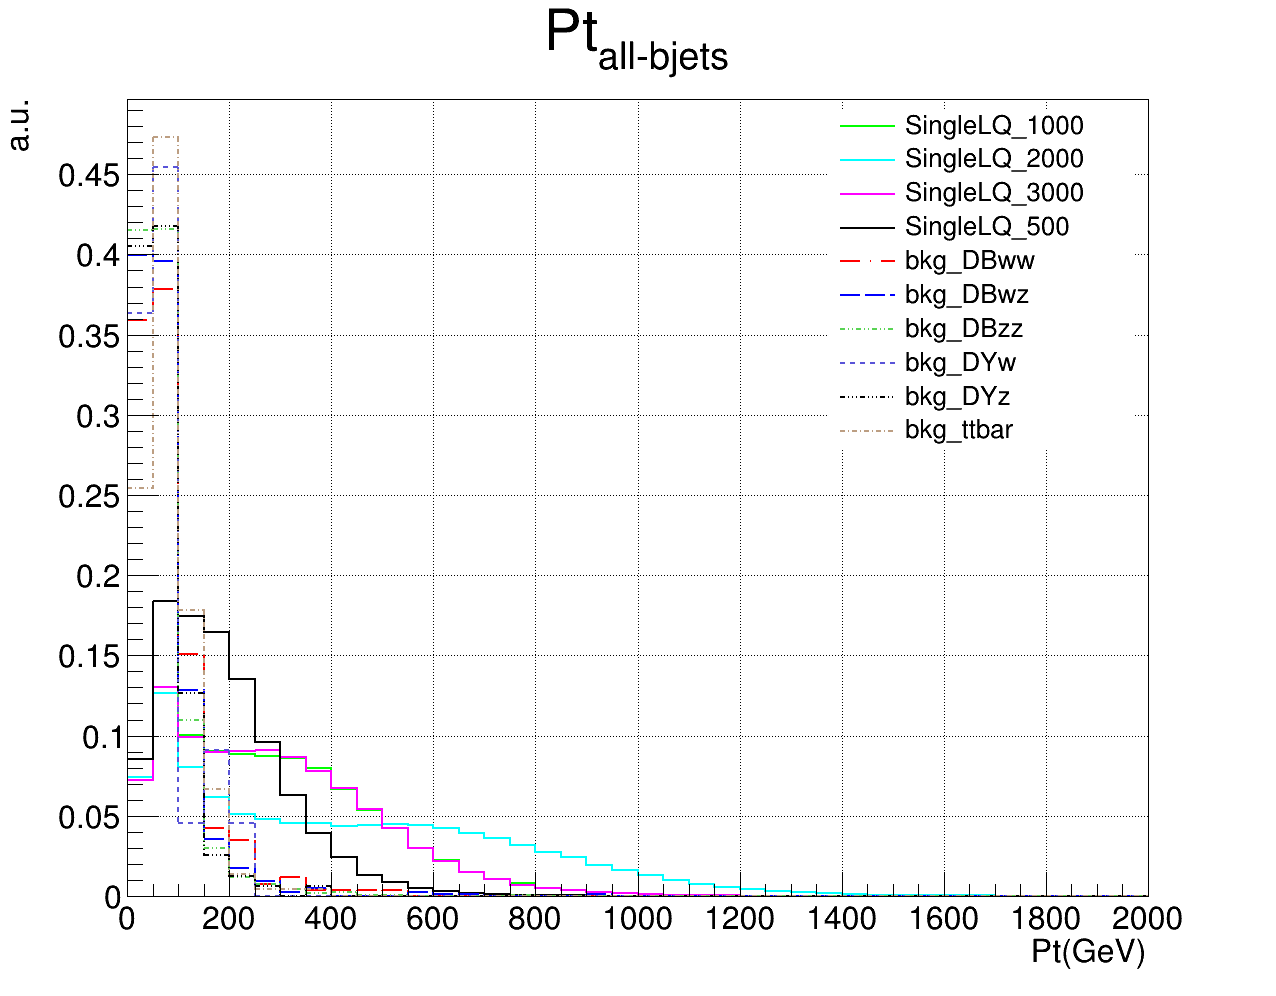

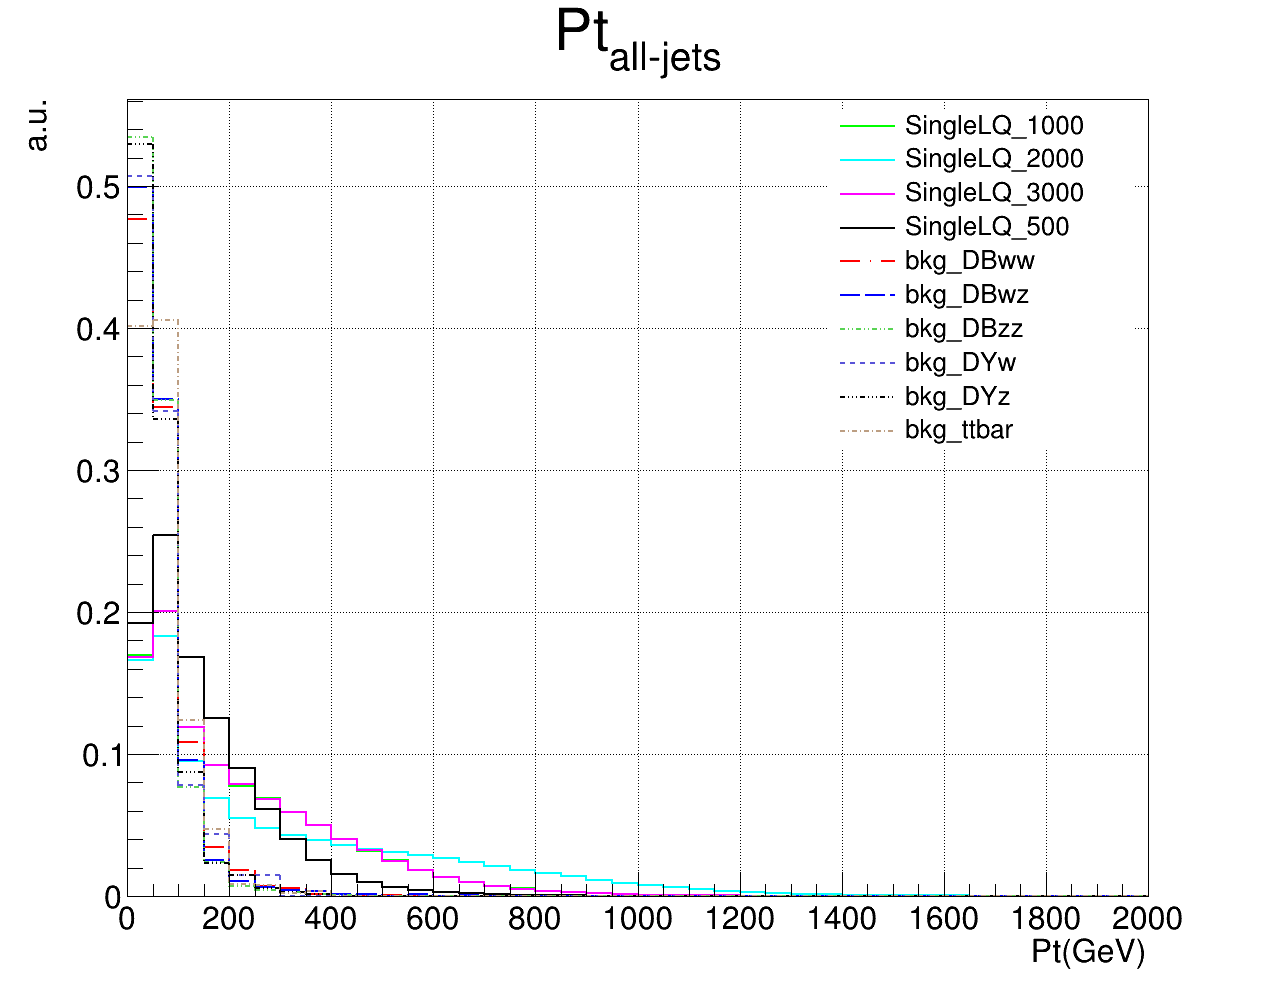

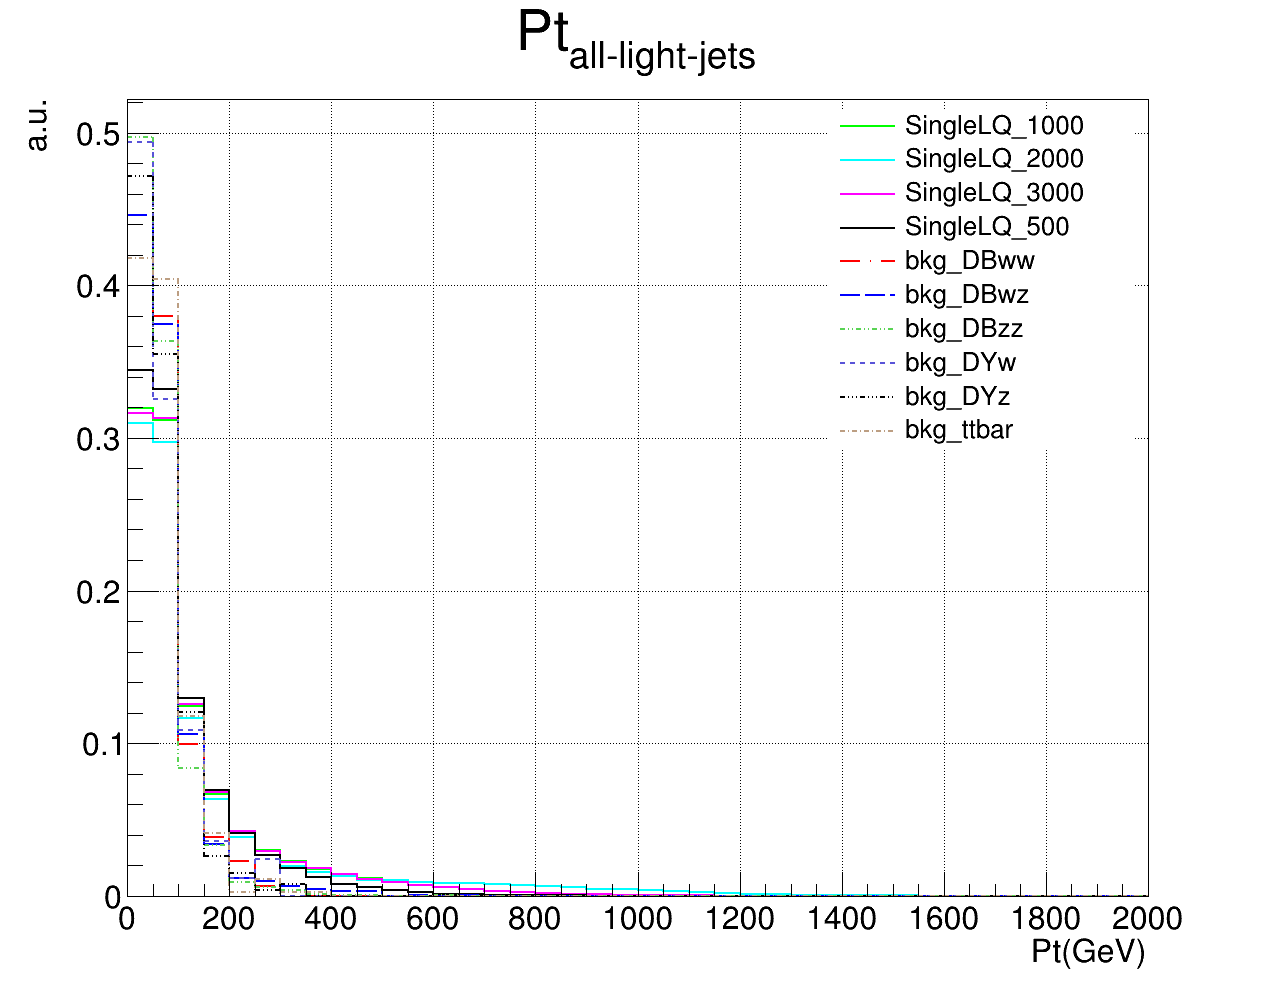

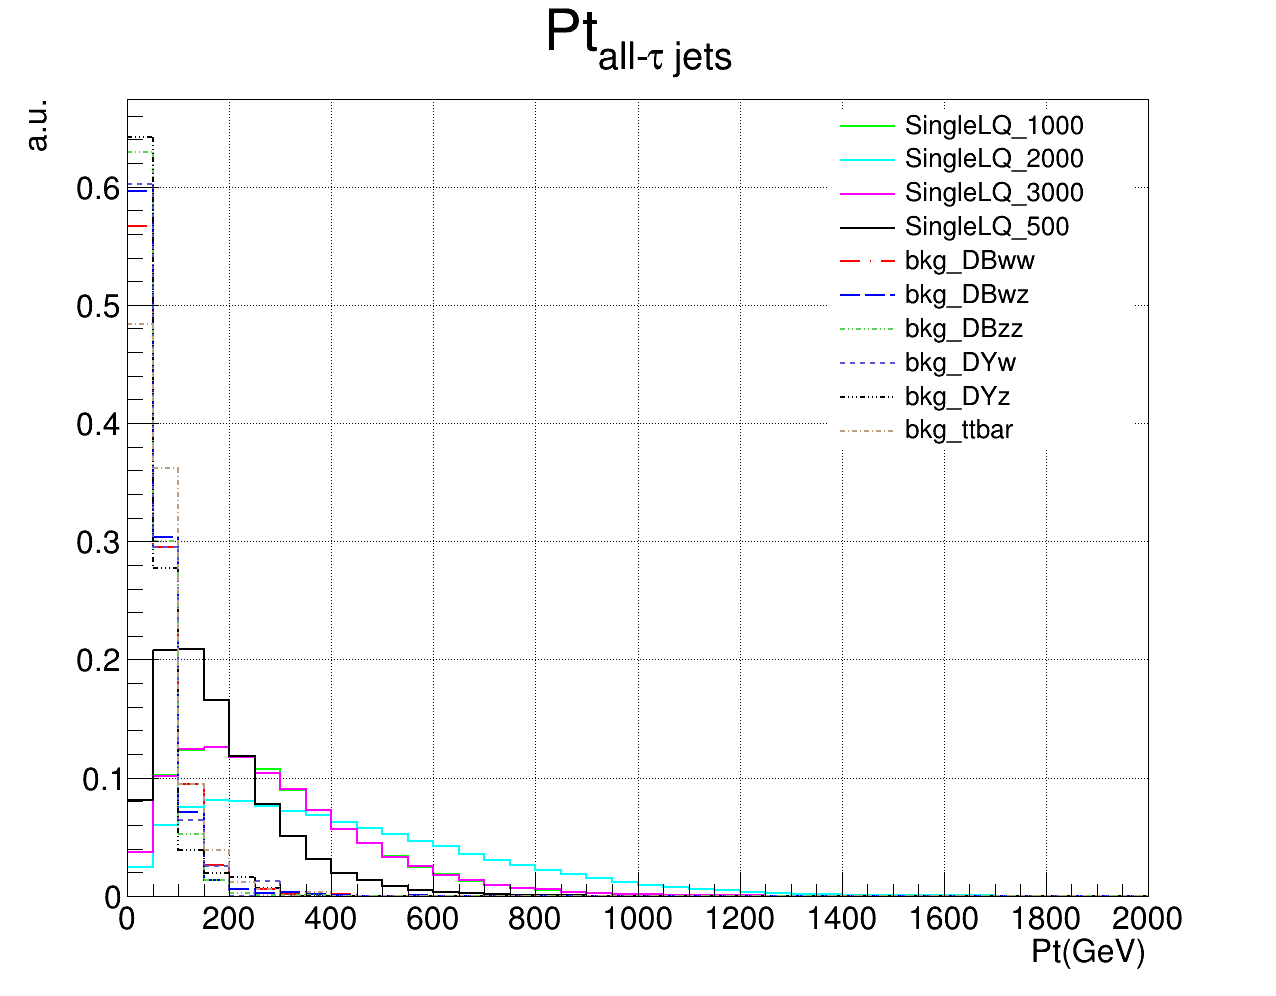

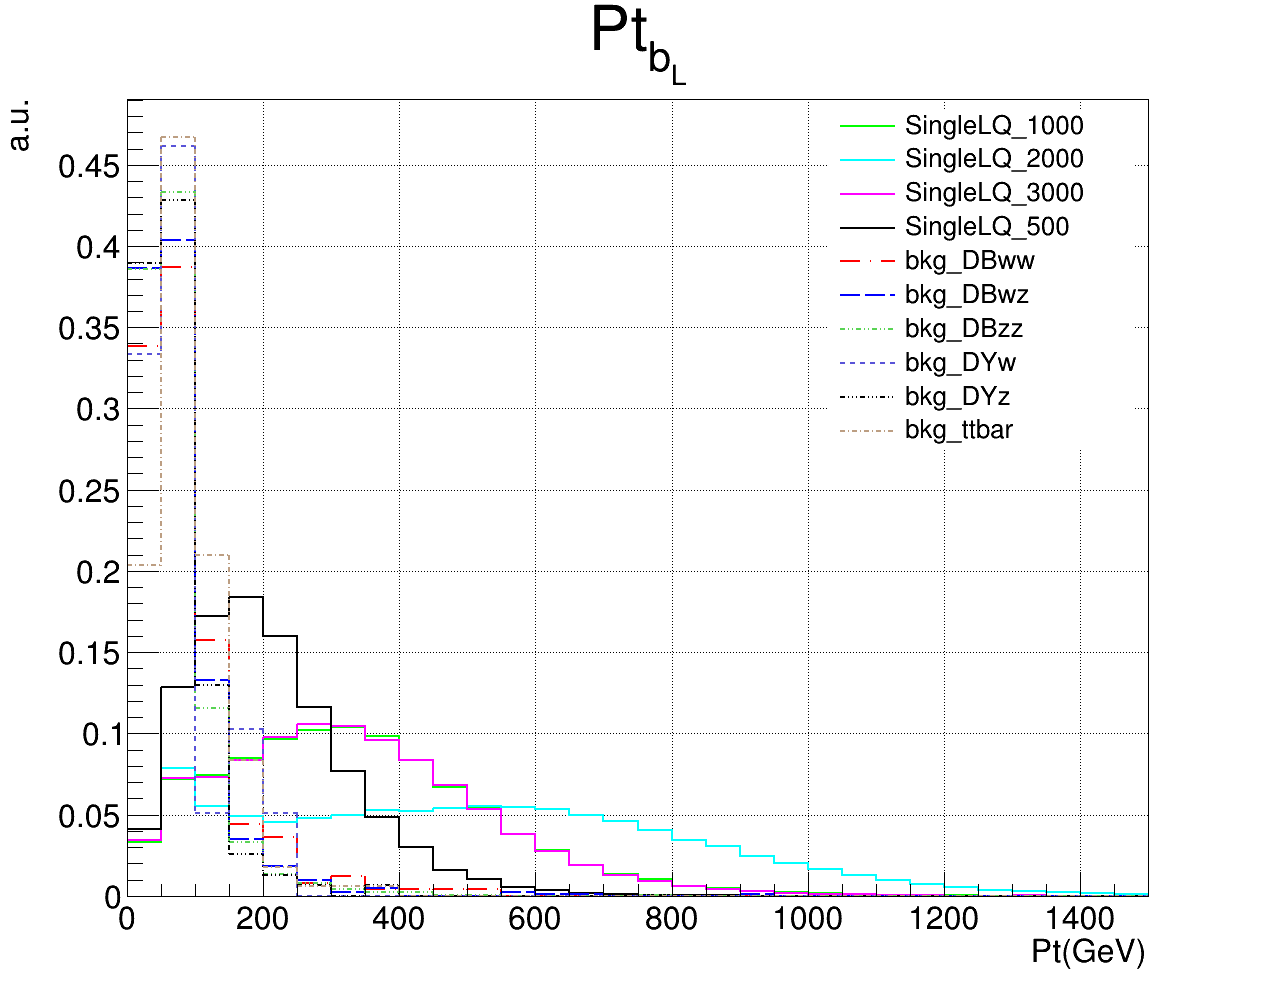

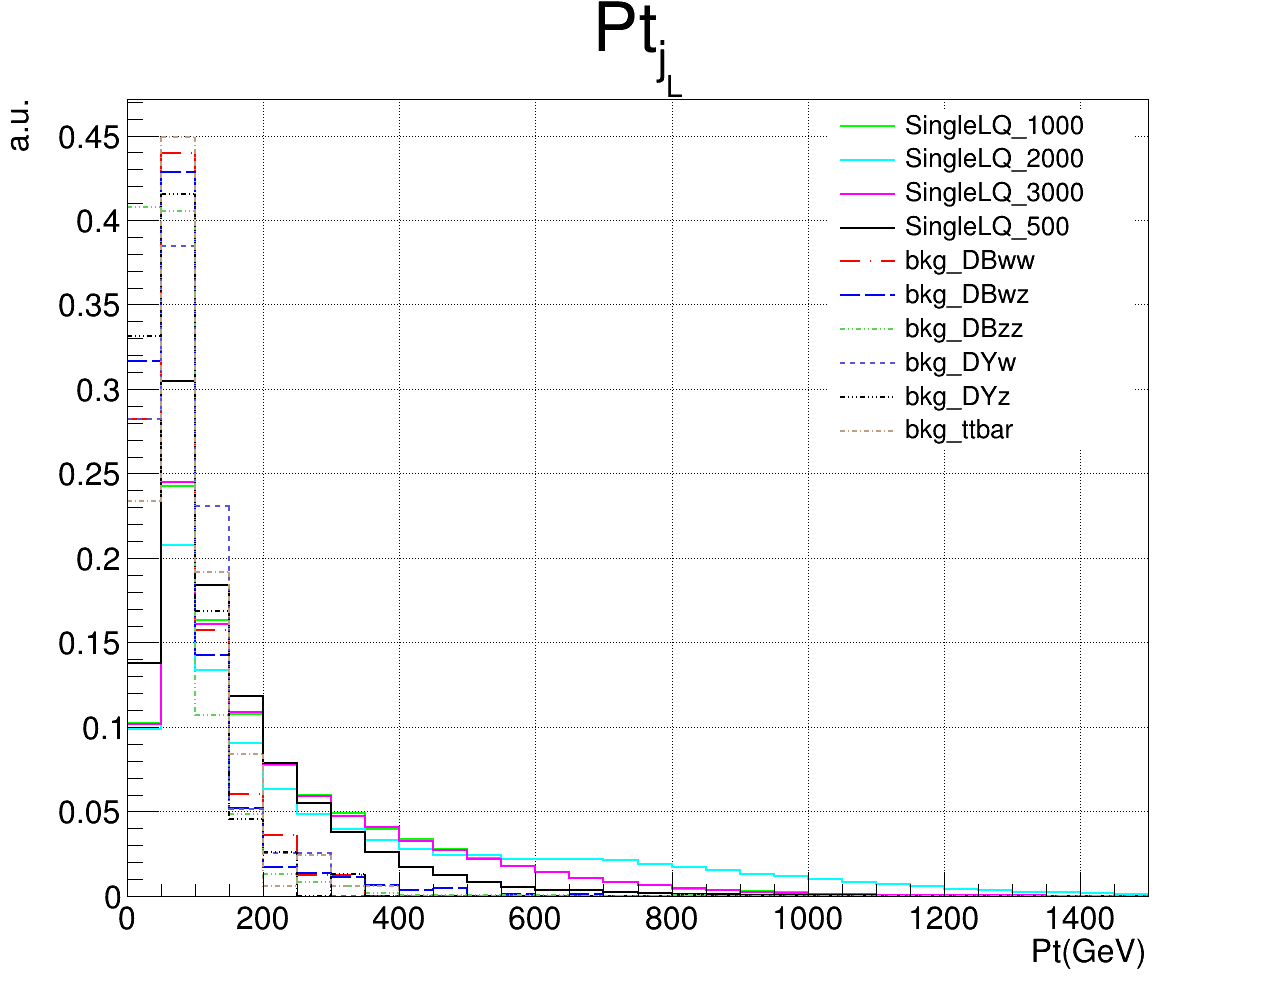

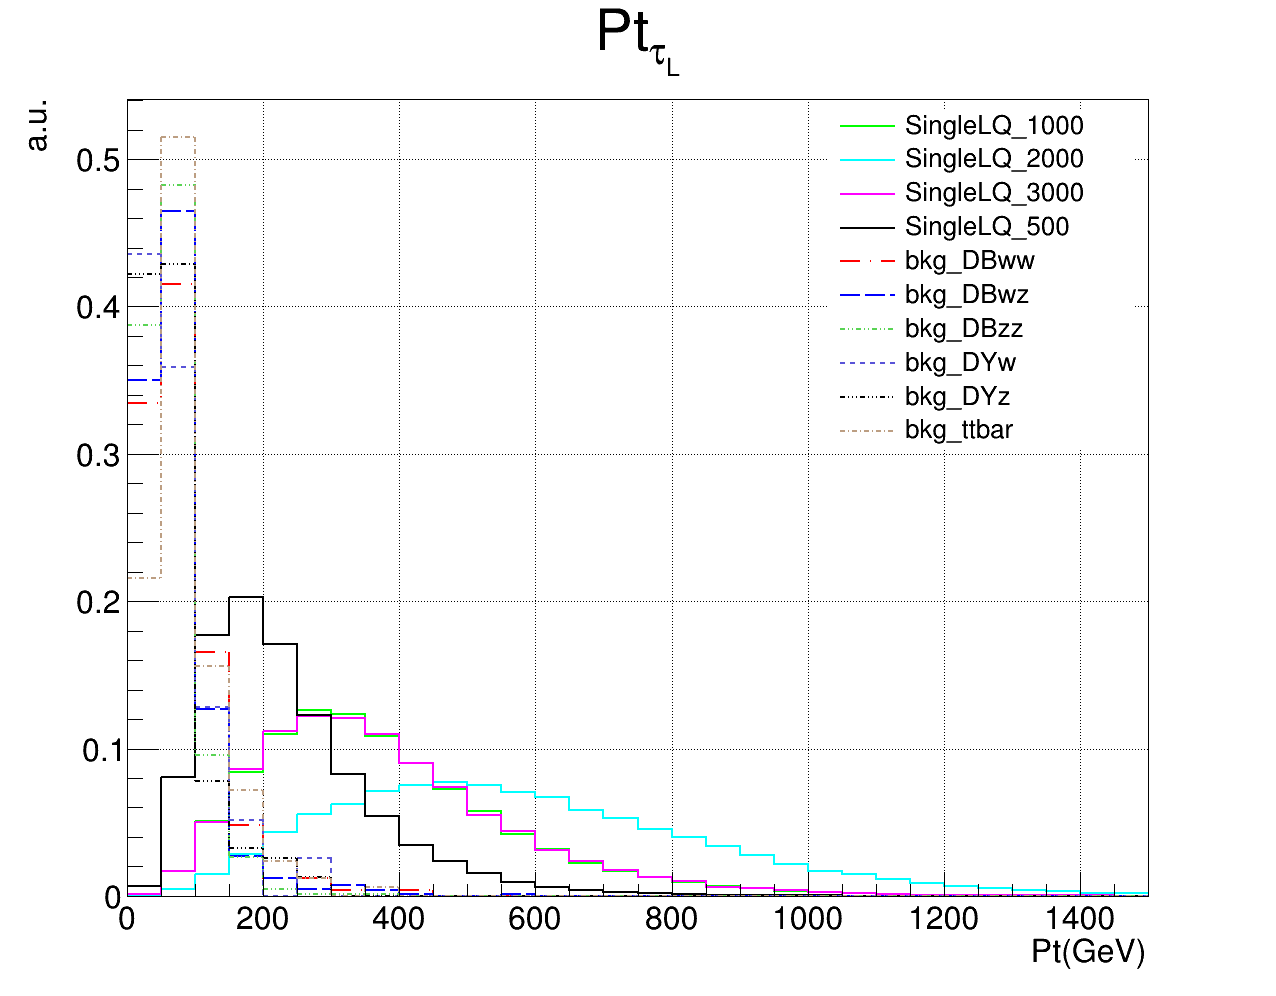

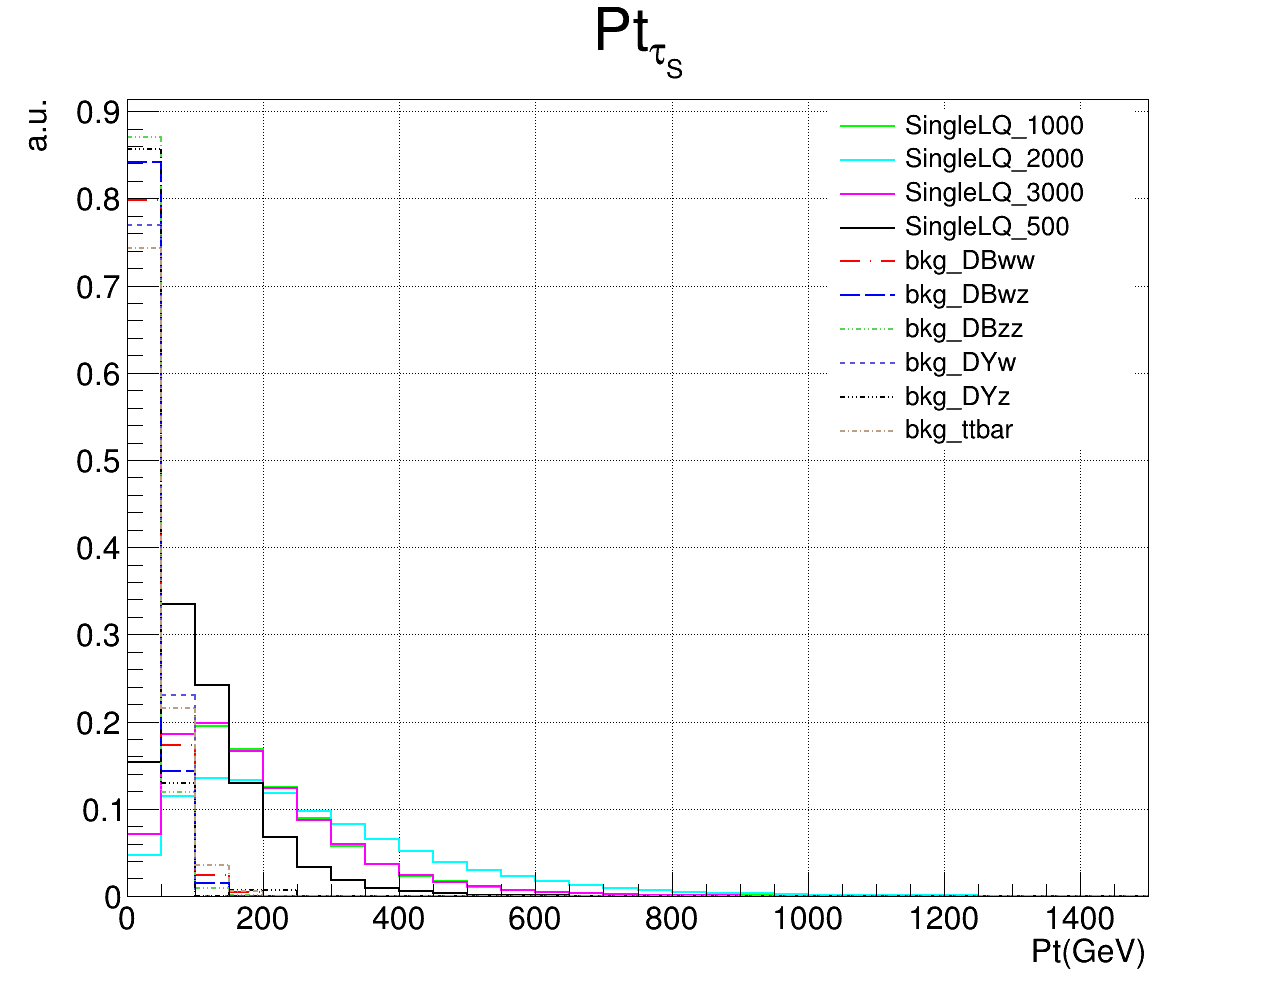

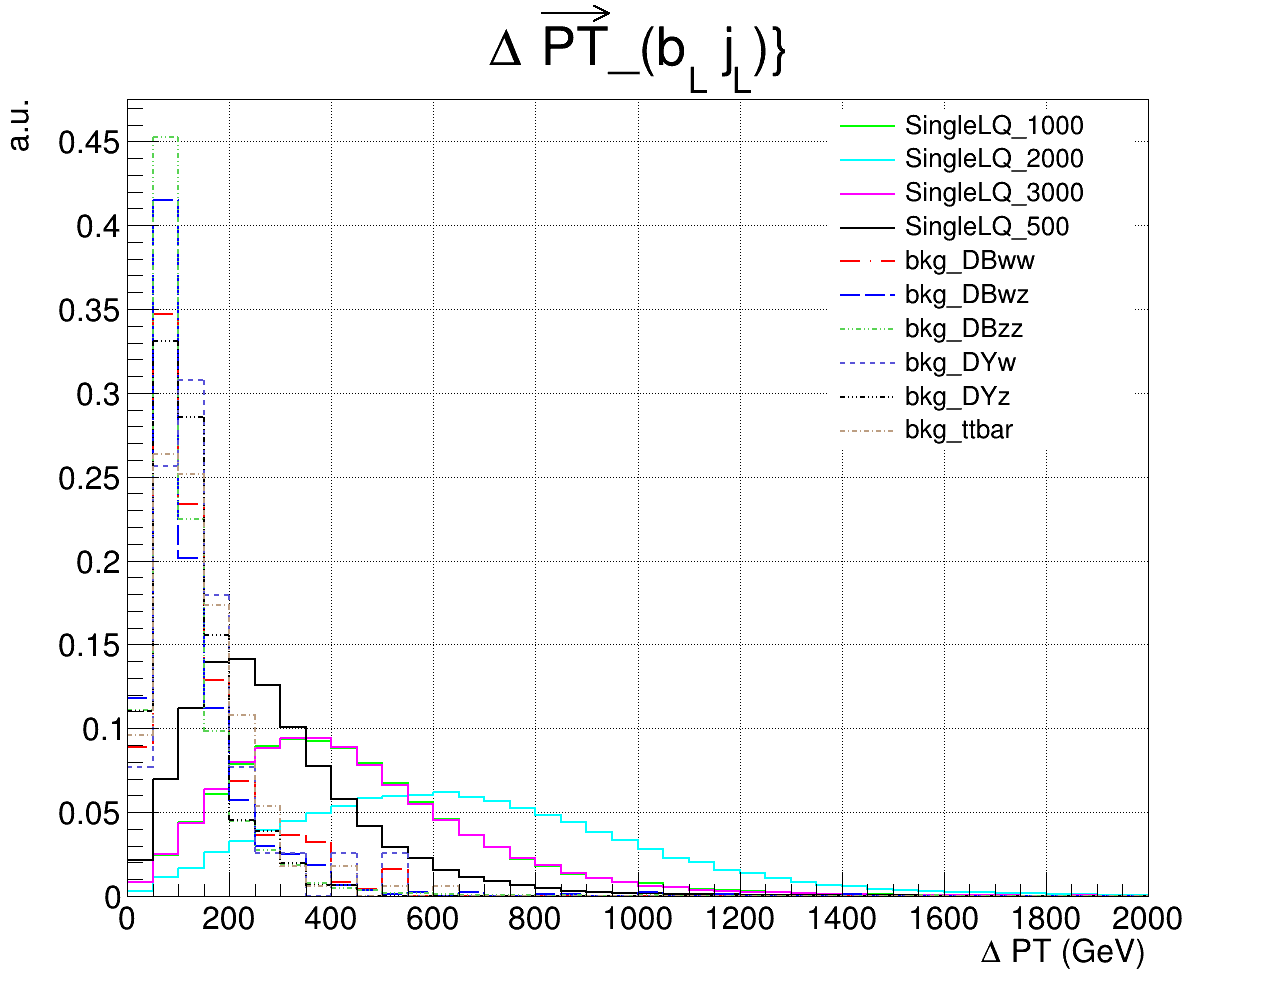

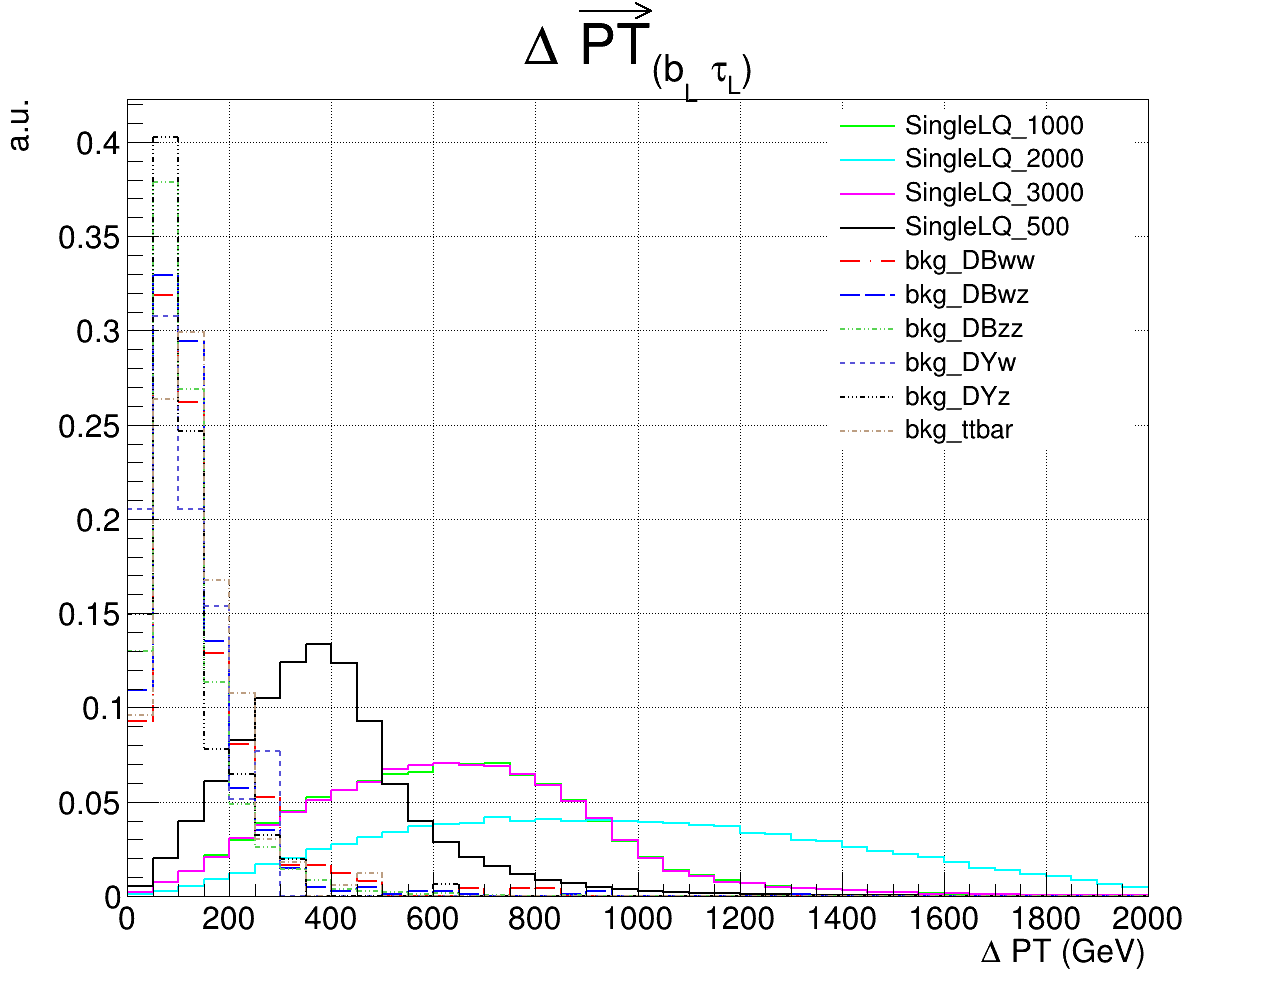

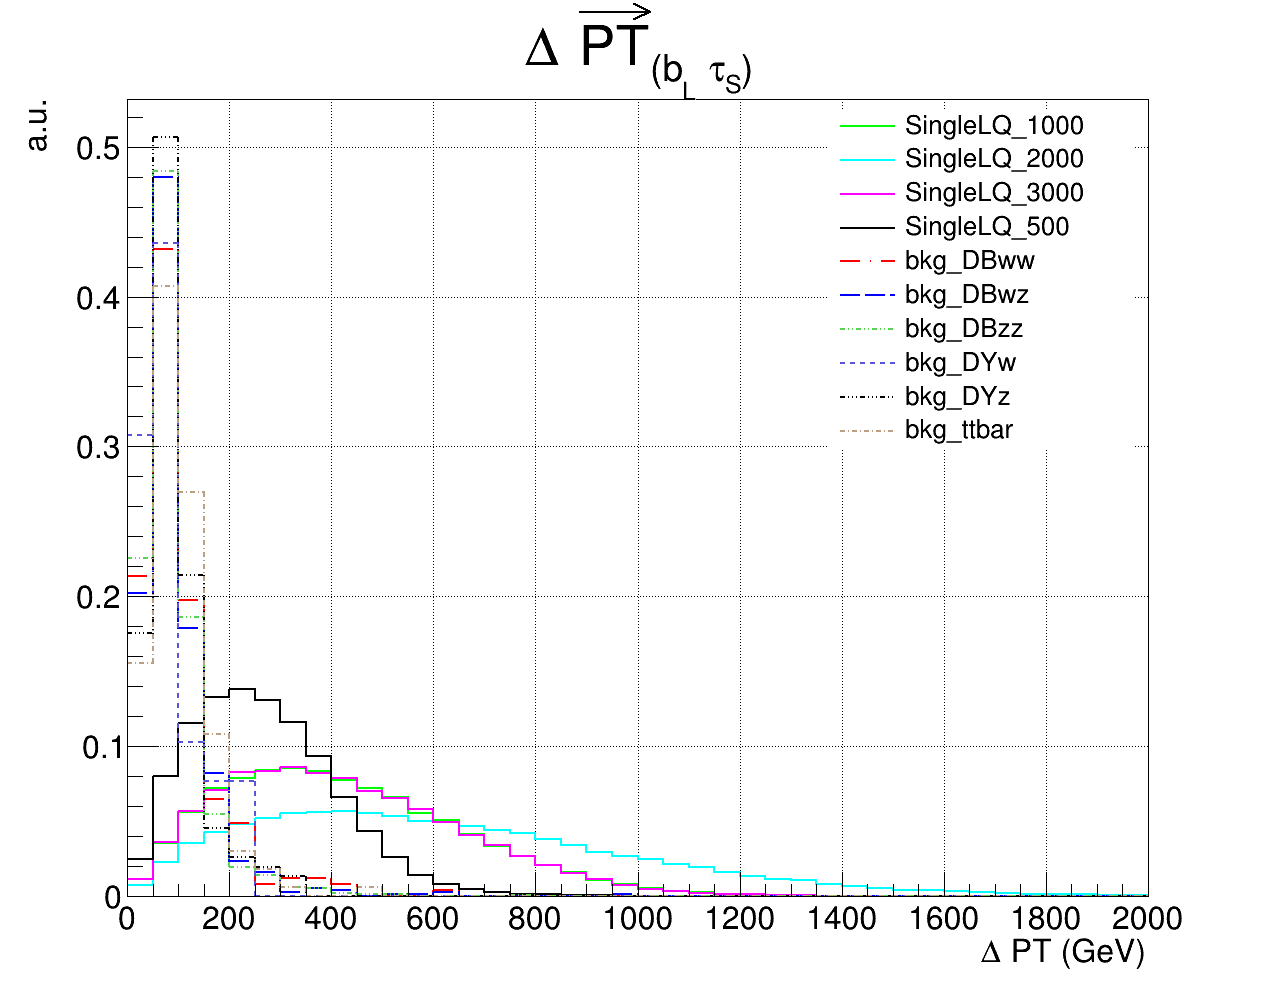

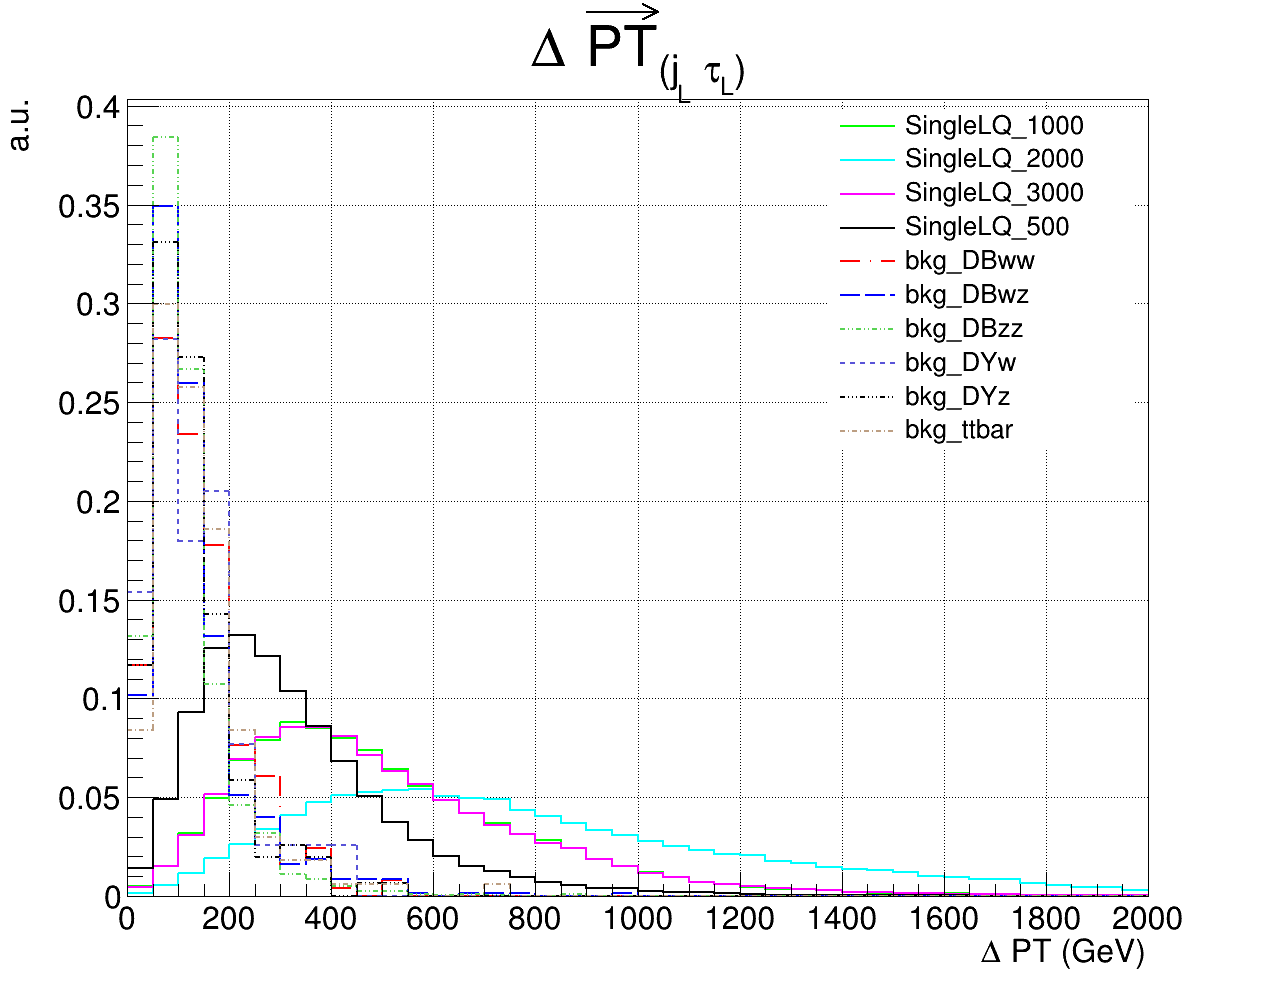

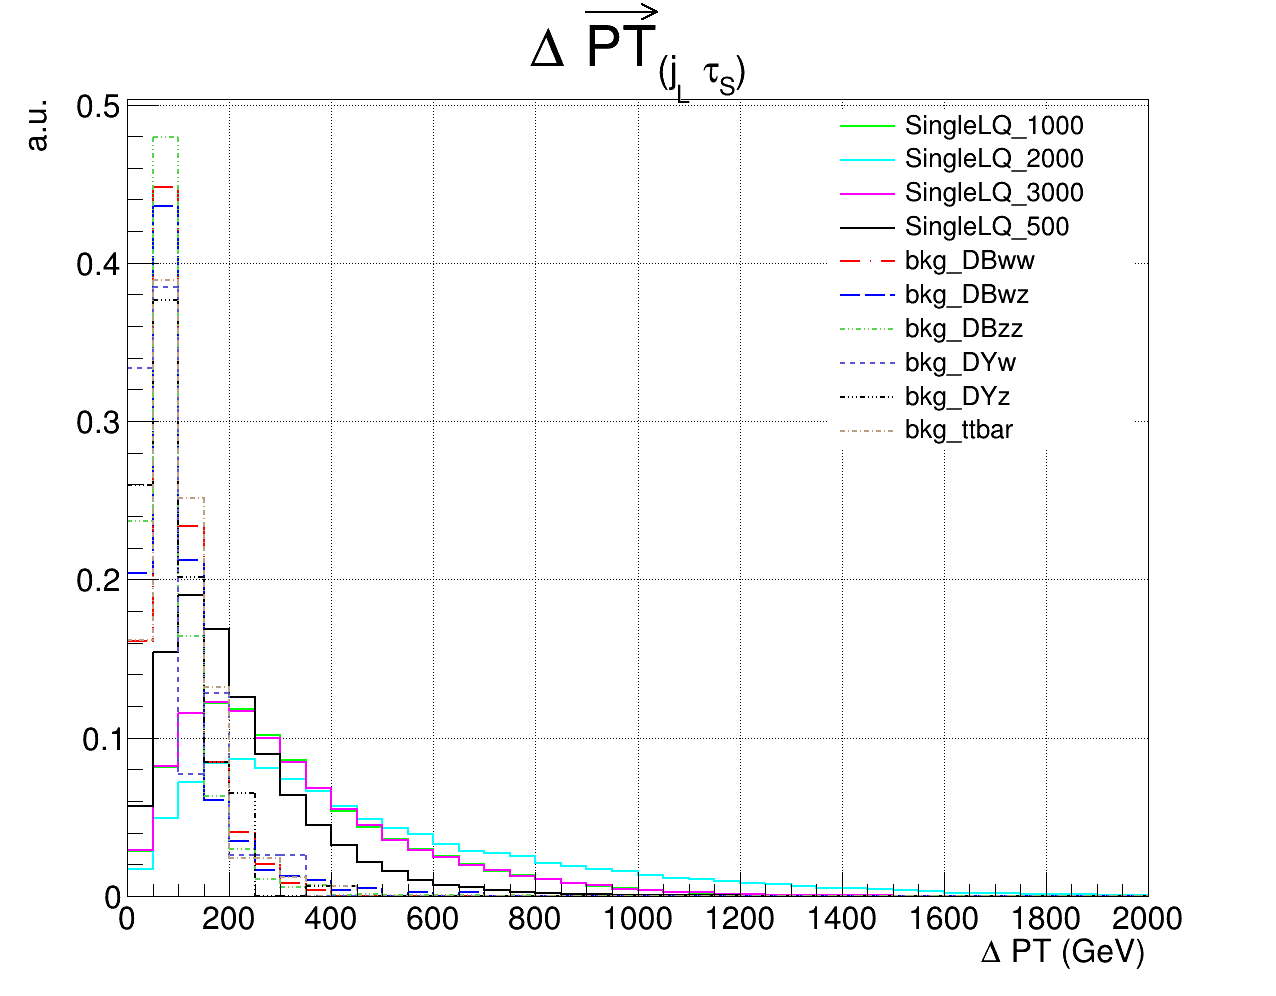

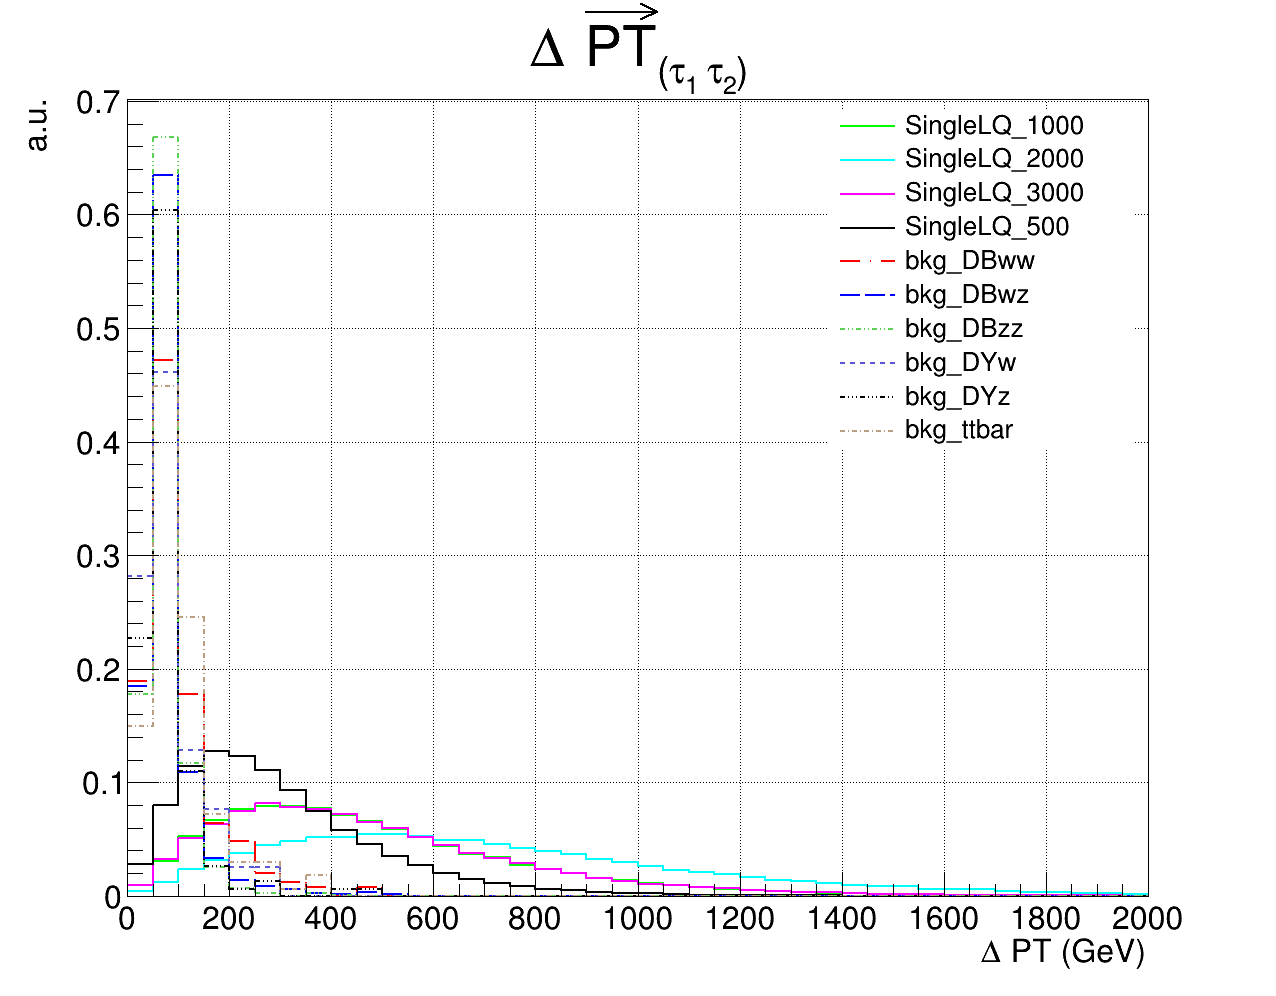

In [23]:
import os
from IPython.display import Image, display

listOfImageNames=[]
current_path = os.getcwd()
files=next(os.walk(current_path))[2]
for file in files:
    if ".png" in file:
        listOfImageNames+=[file]
listOfImageNames.sort()
for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [ ]:
import os
import csv
current_path = os.getcwd()
files=next(os.walk(current_path))[2]
csv_files=[]
for file in files:
    if ".csv" in file:
        if not (file =="SimulationsPaths.csv"):
            csv_files+=[file]
data_dict={}

f=open("SingleLQ_500.csv")
csvreader = csv.reader(f)

def read_csv(file):
    pass
type(csvreader)

In [ ]:
csvreader